In [1]:
import gym
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

from matplotlib import animation
from JSAnimation.IPython_display import display_animation
from IPython.display import display
%matplotlib inline

def display_frames_as_gif(frames):
    patch = plt.imshow(frames[0])
    plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=5)
    display(display_animation(anim, default_mode='loop'))

# Behavior Clonning 

# MountCar Example

### Load data from pickle file

Data file has (s,a) pairs

In [2]:
envname = "MountainCarContinuous-v0"

# Load demonstrations
demo_file = open('./' + envname + '_expert_demo.pkl', 'rb')
demonstrations, = pickle.load(demo_file)
demonstrations = shuffle(demonstrations)

# Check expert's performance
exp_ret = np.mean([np.sum(d['rewards']) for d in demonstrations])
print('Expert\'s Average Cumulative Rewards {:.3f}'.format(exp_ret))

demo_observes = []
demo_actions = []
for demonstration in demonstrations:
    for obs in demonstration['observes']:
        demo_observes.append(obs)
    for act in demonstration['actions']:
        demo_actions.append(act)
demo_observes = np.asarray(demo_observes)
demo_actions = np.asarray(demo_actions)

demo_observes, demo_actions = shuffle(demo_observes, demo_actions)

demo_observes = demo_observes[:100,:]
demo_actions = demo_actions[:100,:]

Expert's Average Cumulative Rewards 92.459


### Print the shape of data
### Find observation dimension and action dimension

In [3]:
obs_dim = (100, 2)
act_dim = (100, 1)

print("Observation data has shape {}".format(demo_observes.shape))
print("Action data has shape {}".format(demo_actions.shape))

Observation data has shape (100, 2)
Action data has shape (100, 1)


### Run Gaussian Process Regression

In [4]:
kernel = C(1.0, (1e-3, 1e3)) * RBF(1, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

demo_obs_mean = np.mean(demo_observes, axis=0, keepdims=True)
demo_obs_std = np.std(demo_observes, axis=0, keepdims=True)
nz_demo_observes = (demo_observes - demo_obs_mean) / demo_obs_std

gpr = gp.fit(nz_demo_observes, demo_actions)


/home/pil-kso/anaconda3/envs/deep-learning-19/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.03171158,  0.01100243]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 69, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)
/home/pil-kso/anaconda3/envs/deep-learning-19/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.01854706, -0.01510702]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 87, 'nit': 13, 'warnflag': 2}
  ConvergenceWarning)
/home/pil-kso/anaconda3/envs/deep-learning-19/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([5.34057617e-05, 3.11263619e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 77, 'nit': 15, 'warnflag': 2}
  Convergen

### Test GPR controller!

[2020-03-29 21:01:15,118] Making new env: MountainCarContinuous-v0
/home/pil-kso/anaconda3/envs/deep-learning-19/lib/python3.6/site-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Total Reward : 94.67



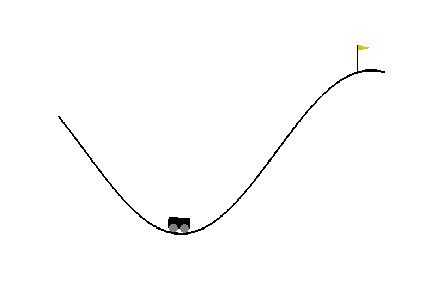
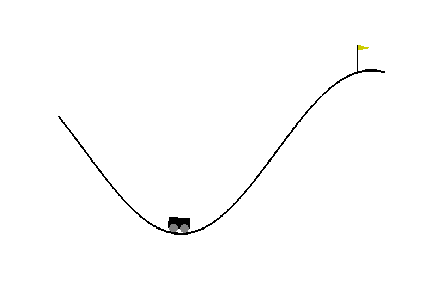
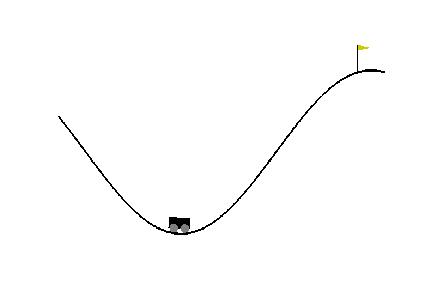
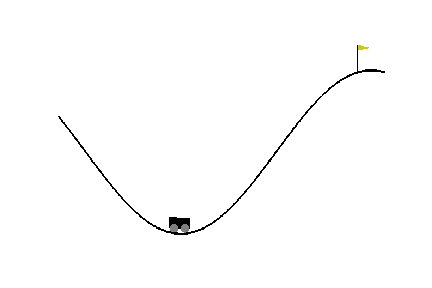
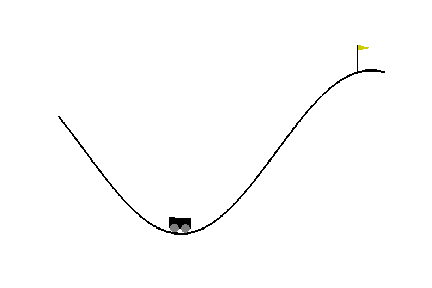
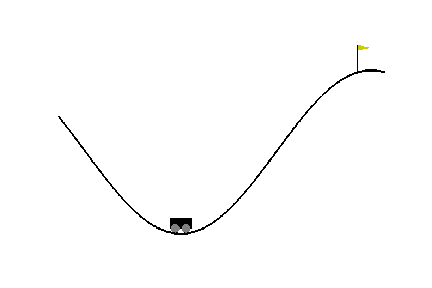
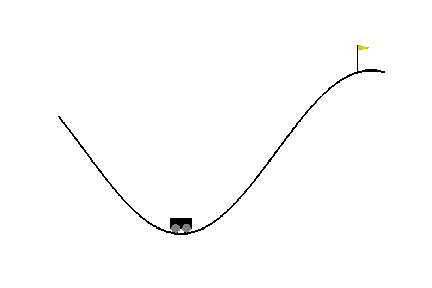
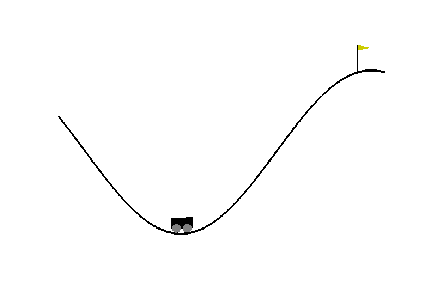
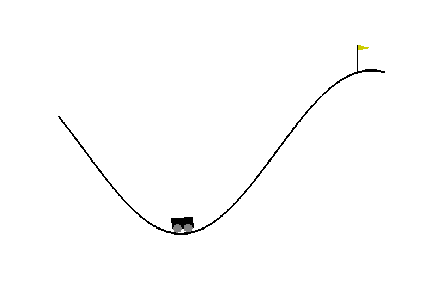
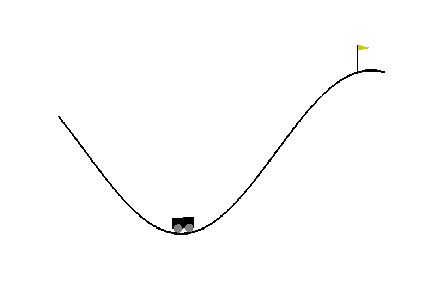
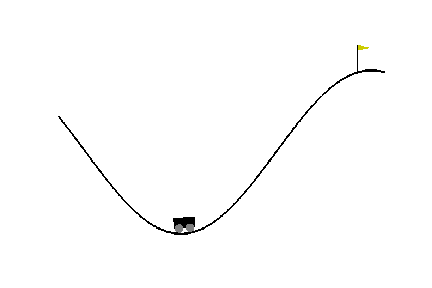
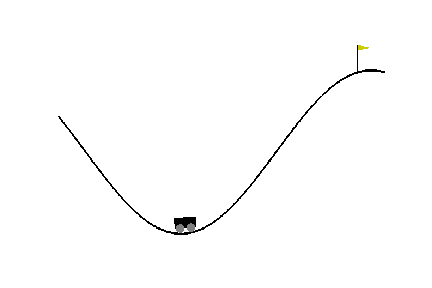
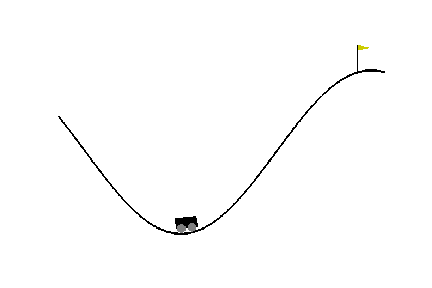
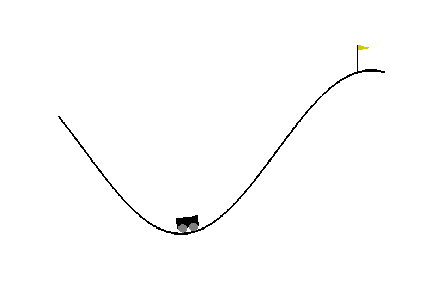
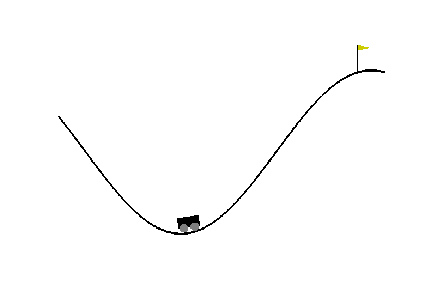
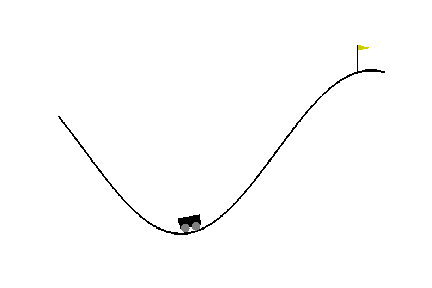
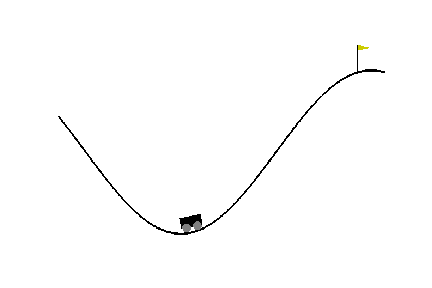
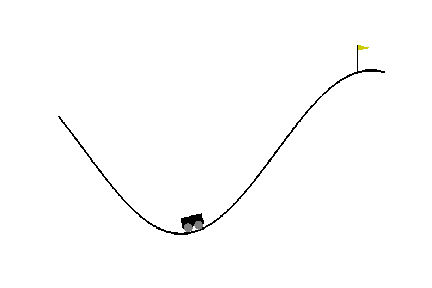
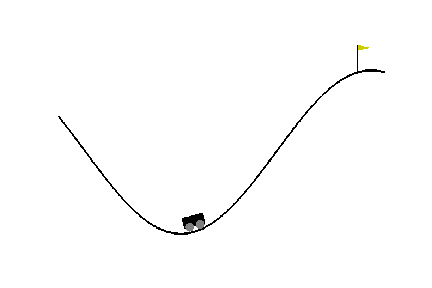
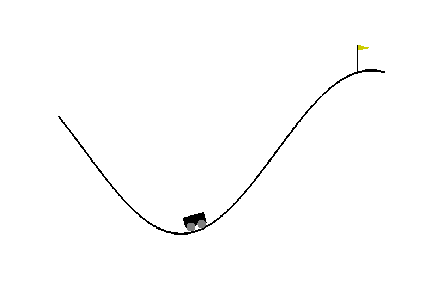
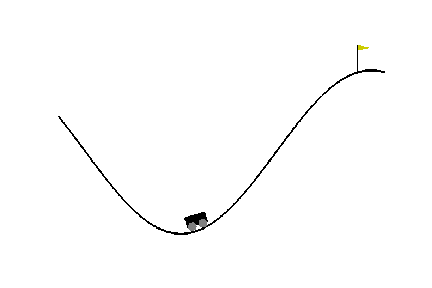
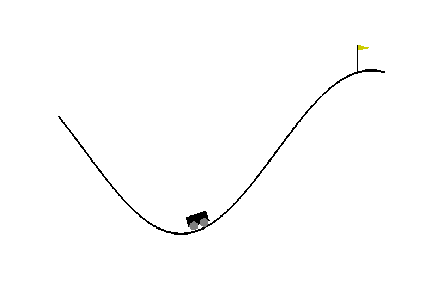
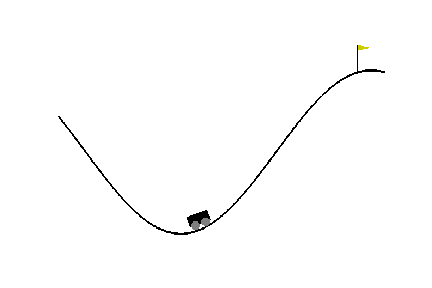
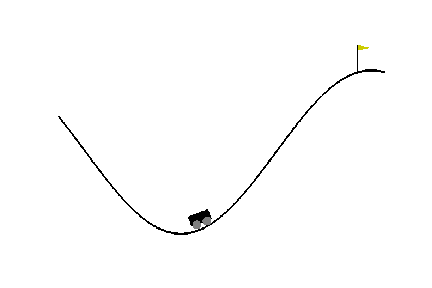
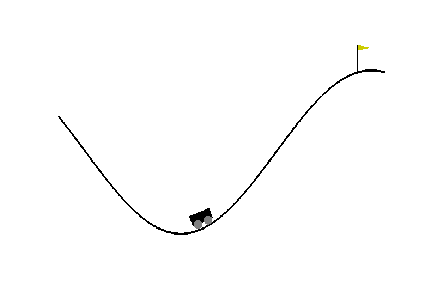
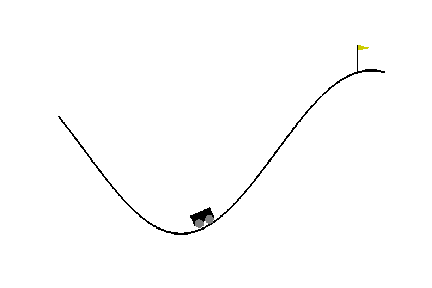
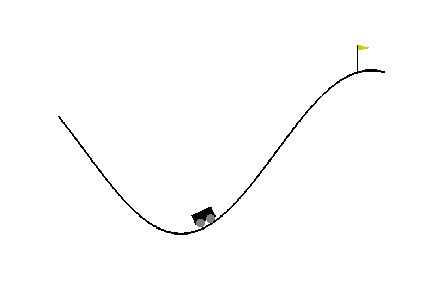
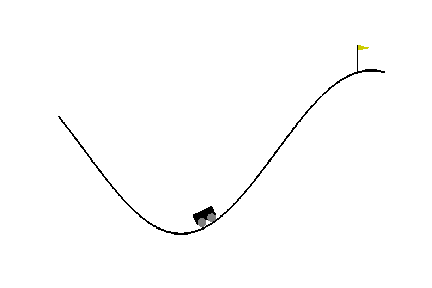
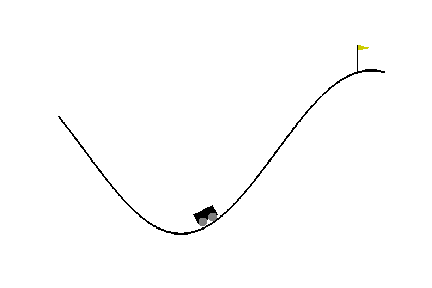
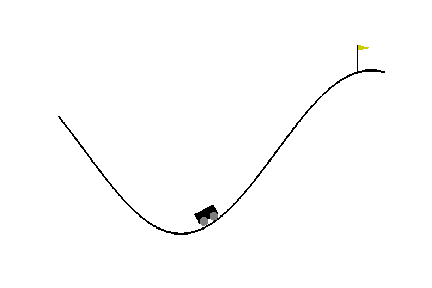
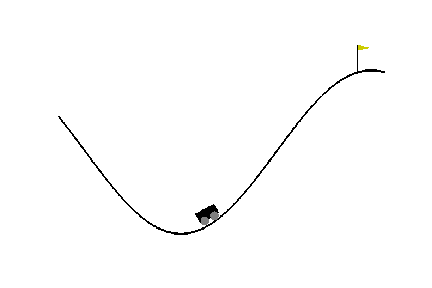
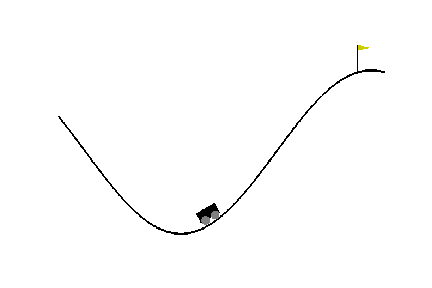
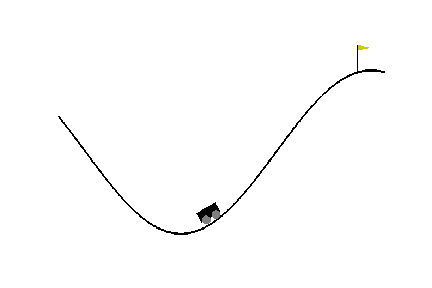
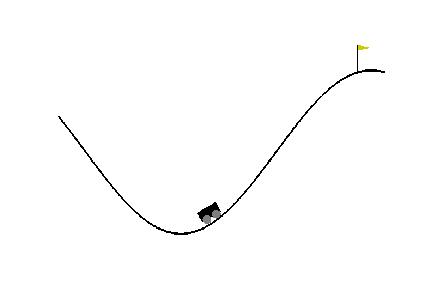
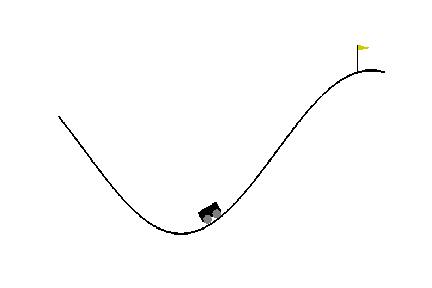
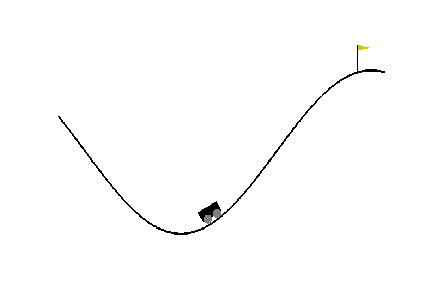
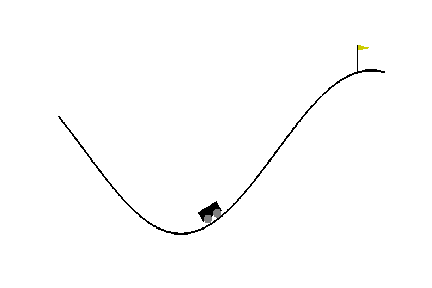
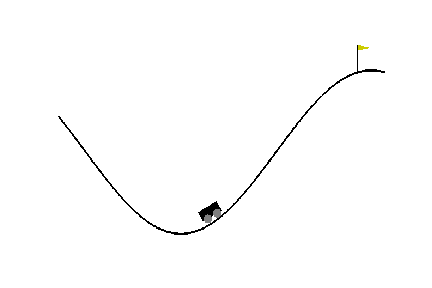
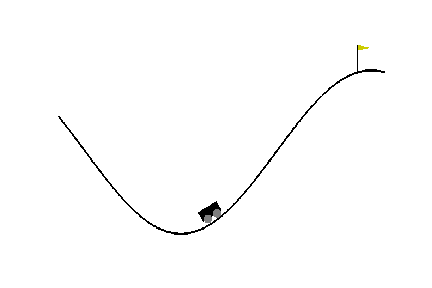
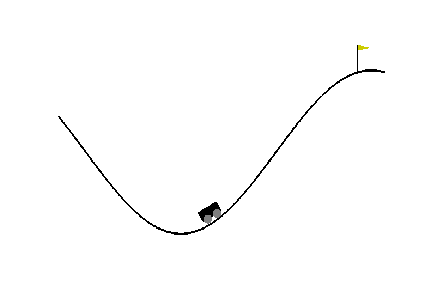
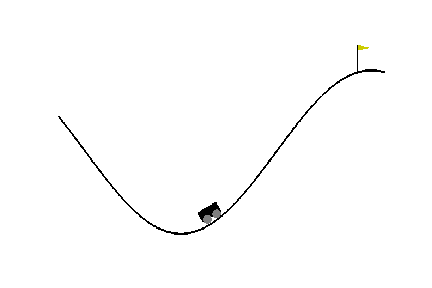
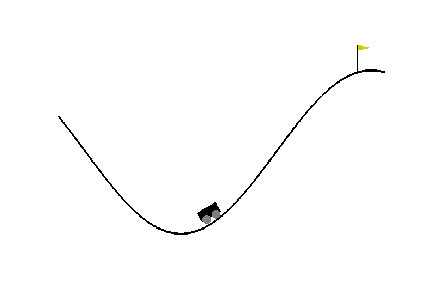
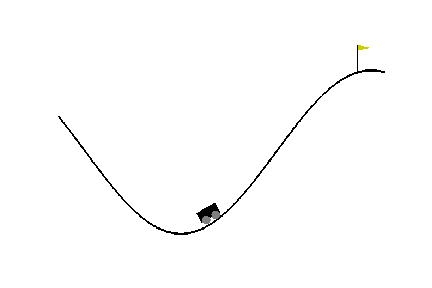
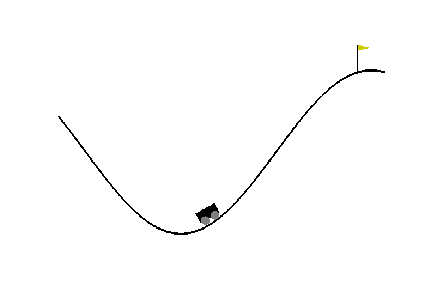
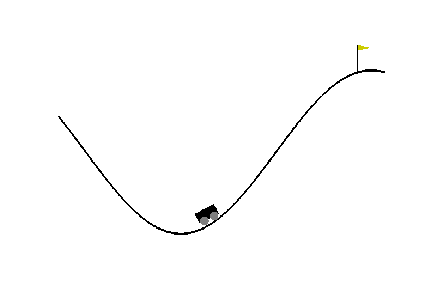
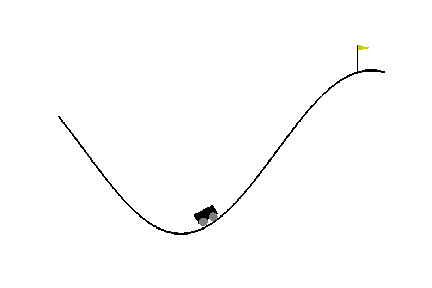
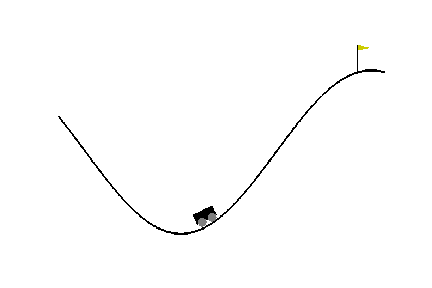
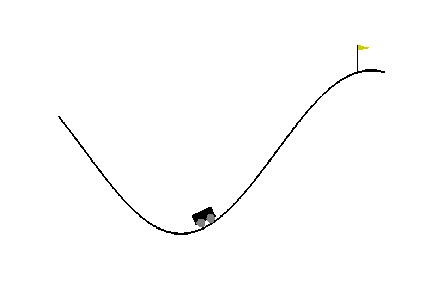
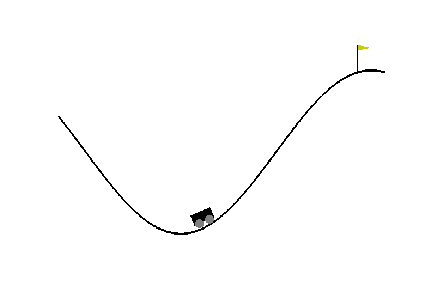
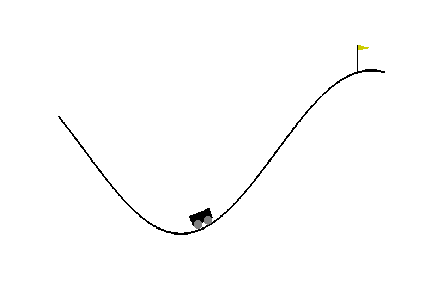
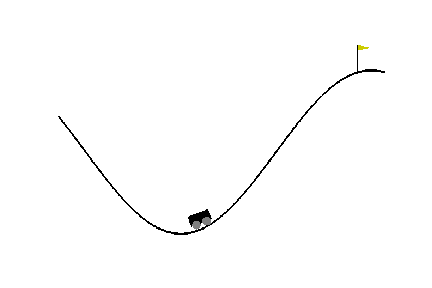
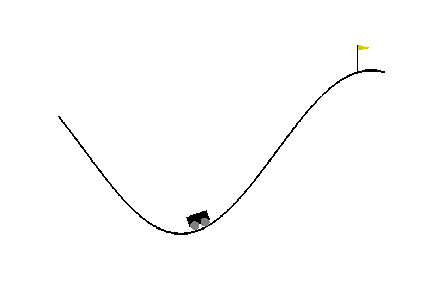
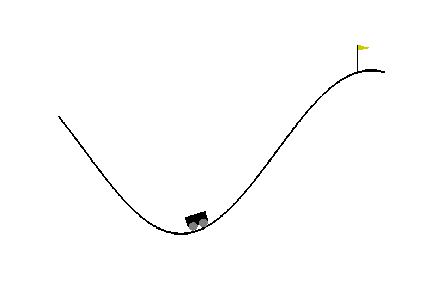
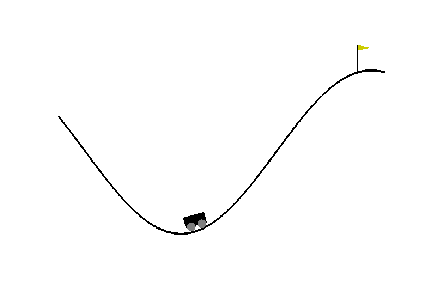
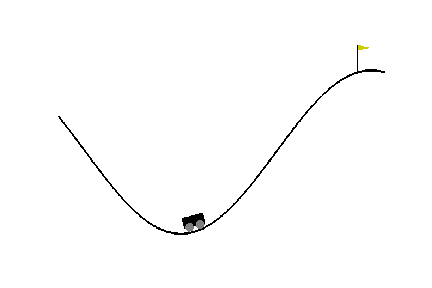
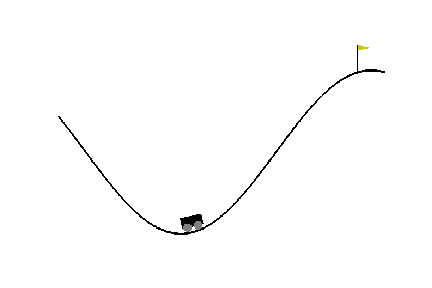
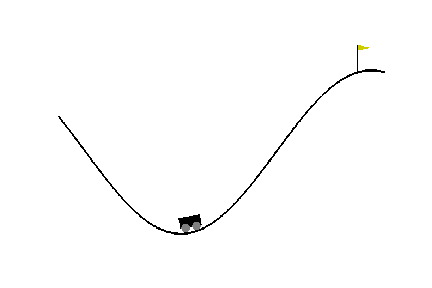
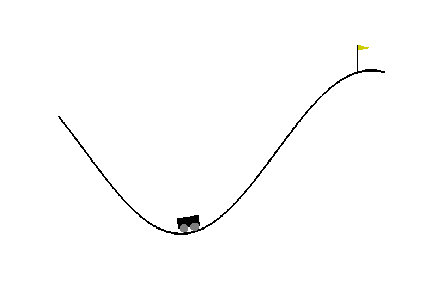
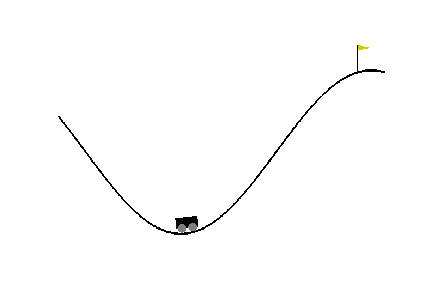
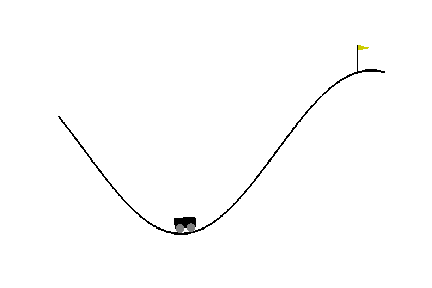
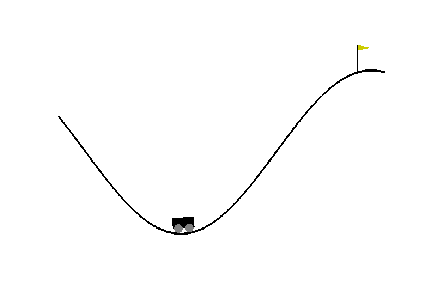
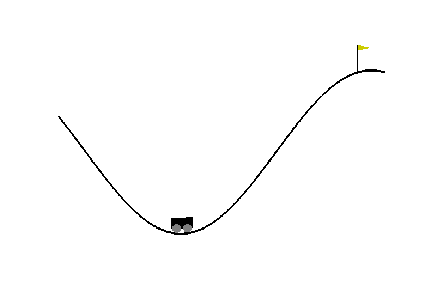
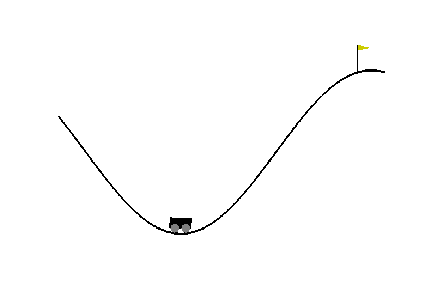
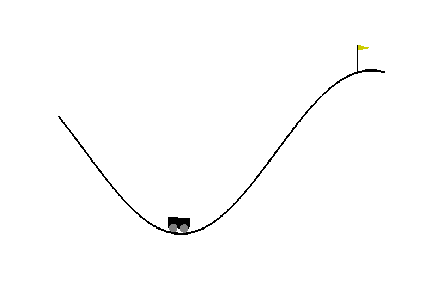
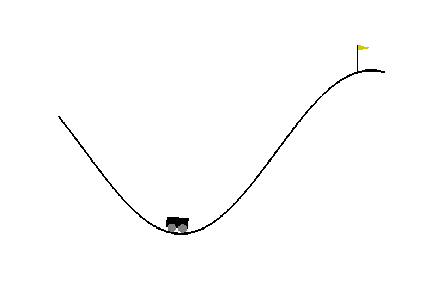
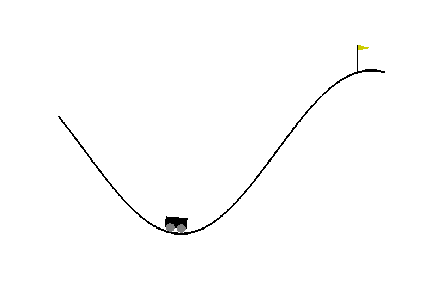
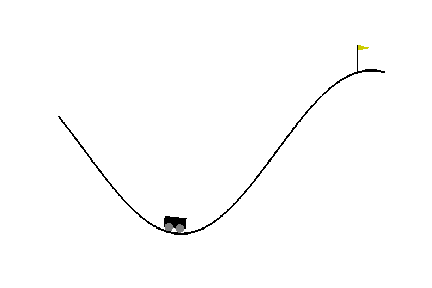
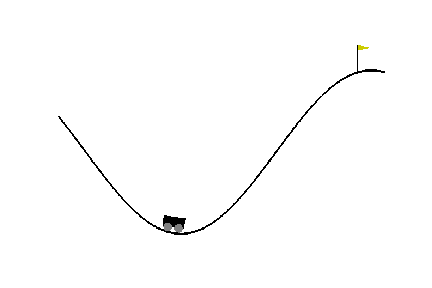
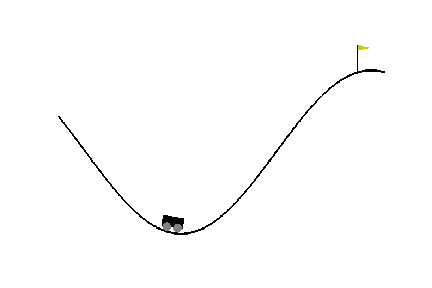
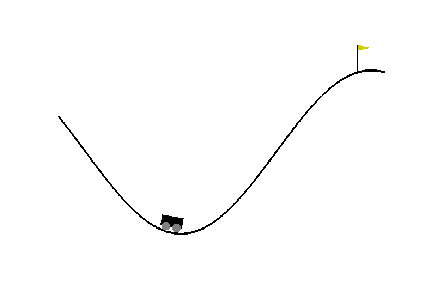
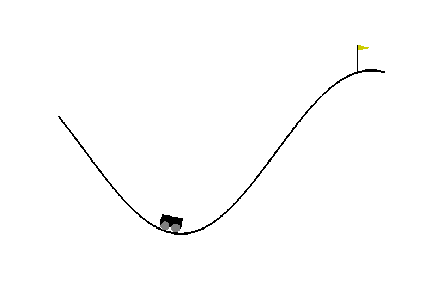
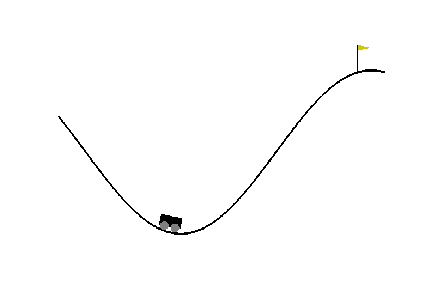
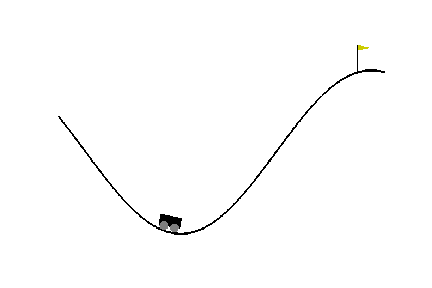
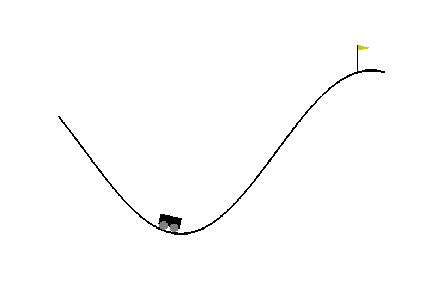
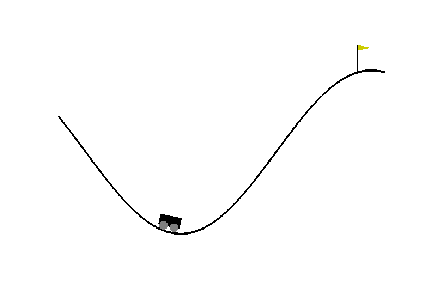
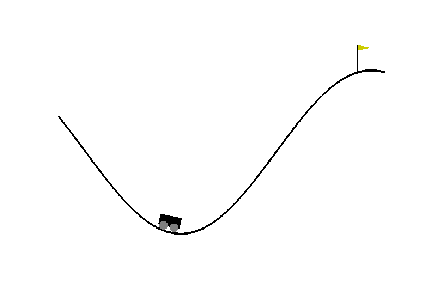
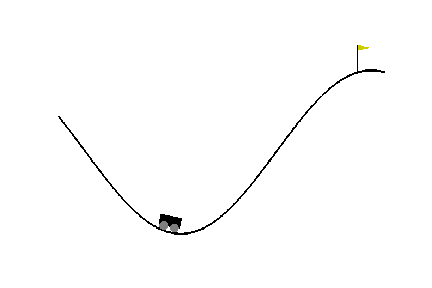
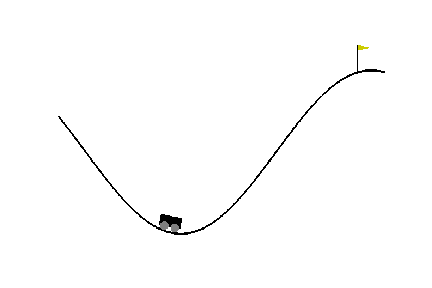
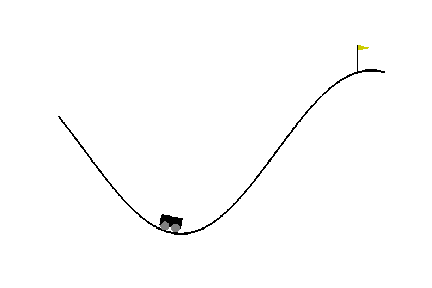
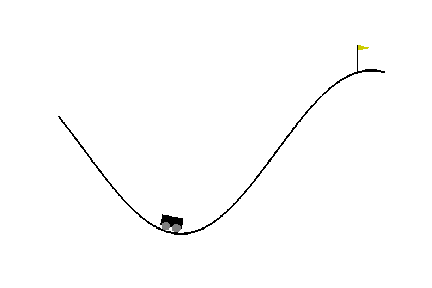
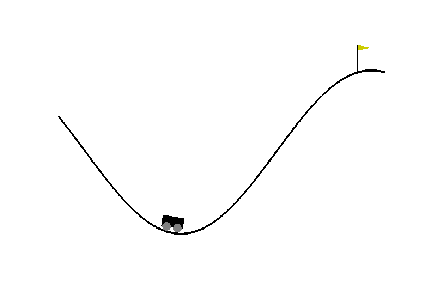
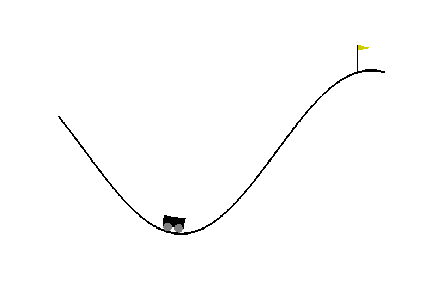
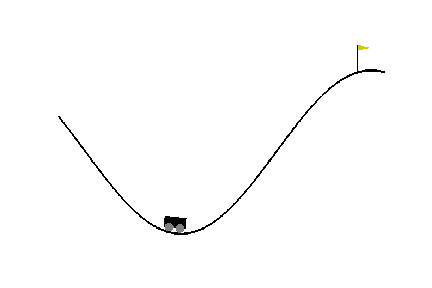
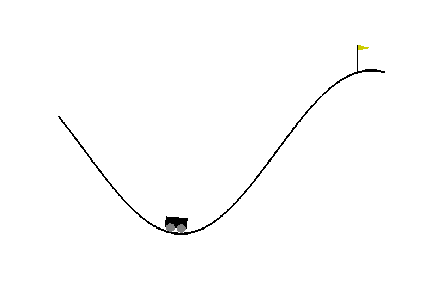
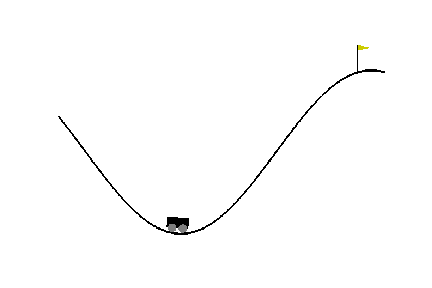
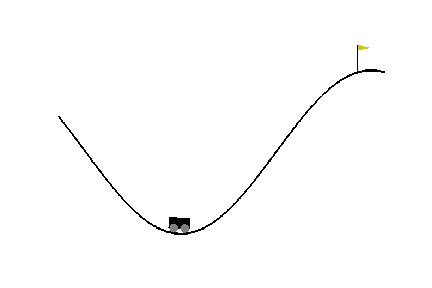
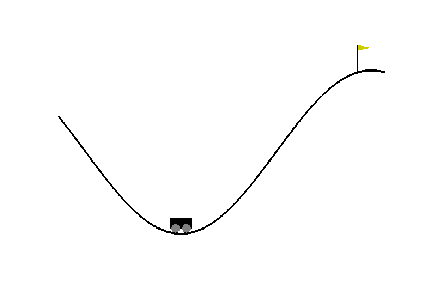
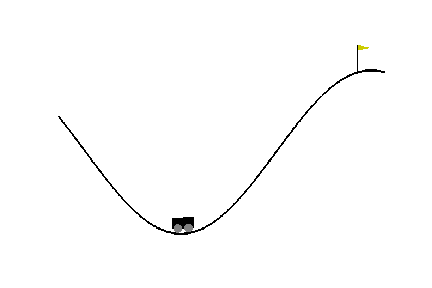
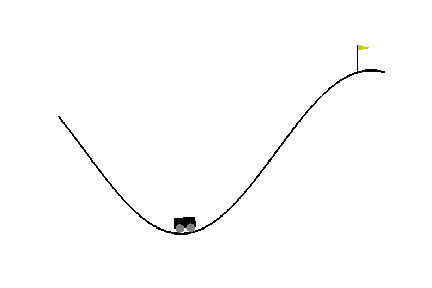
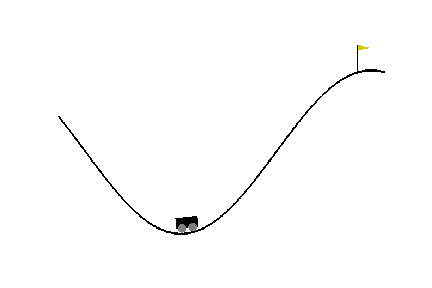
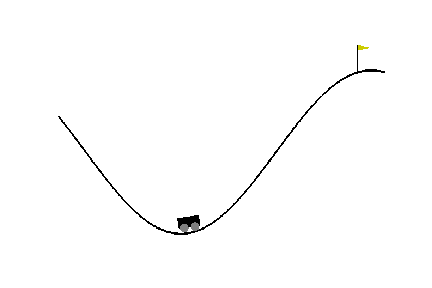
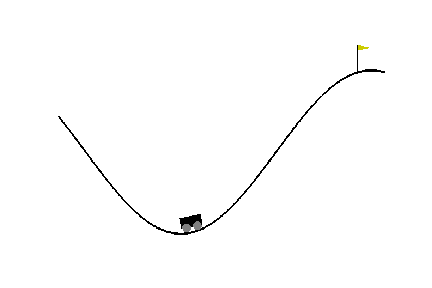
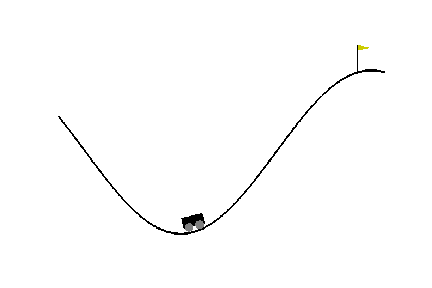
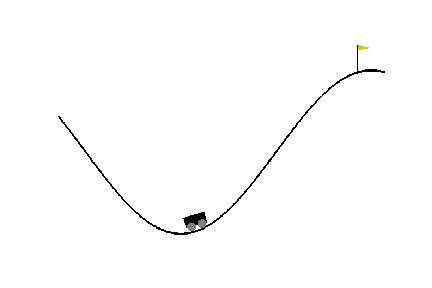
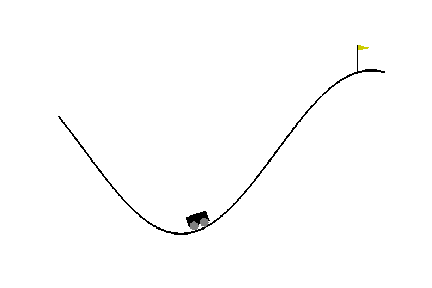
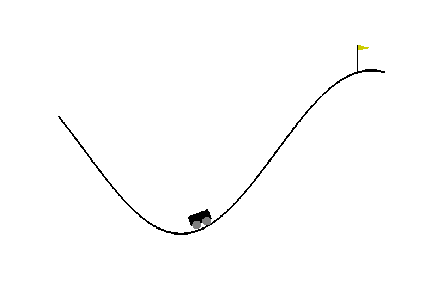
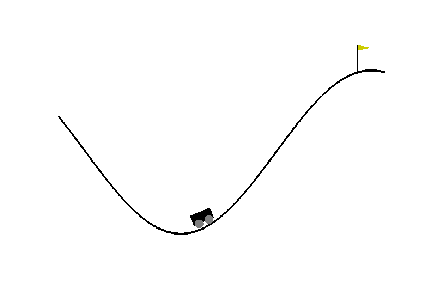
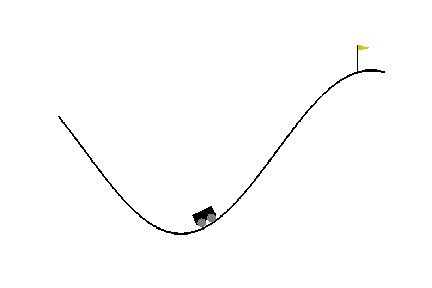
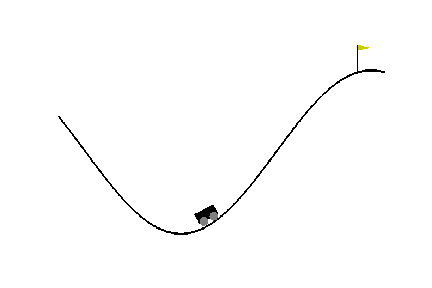
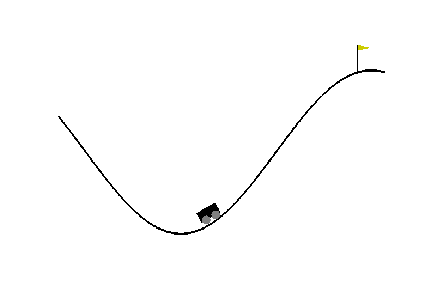
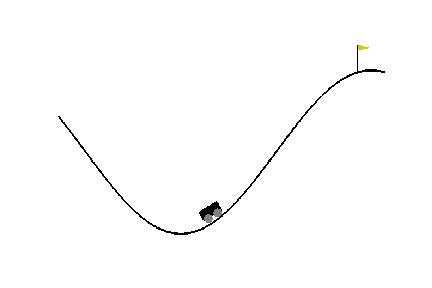
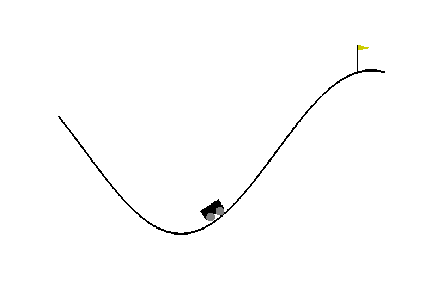
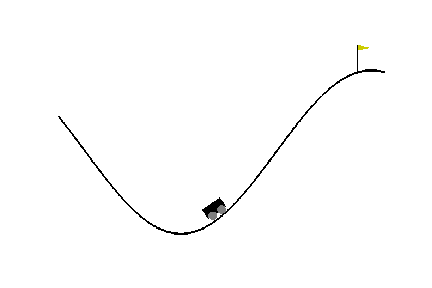
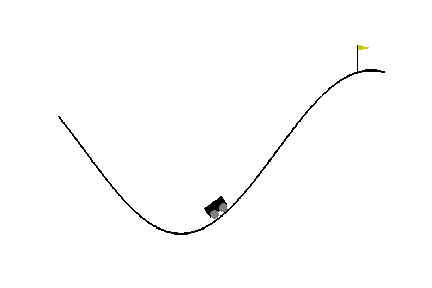
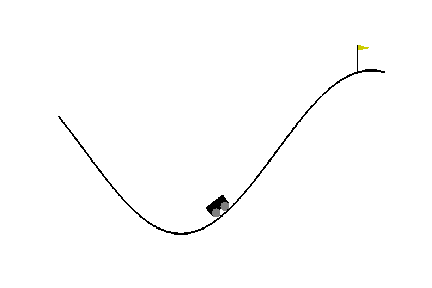
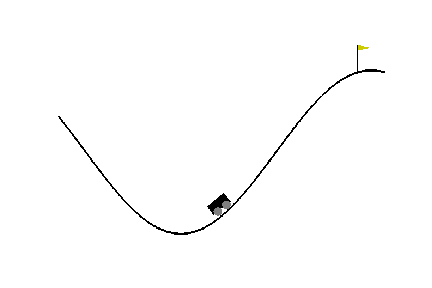
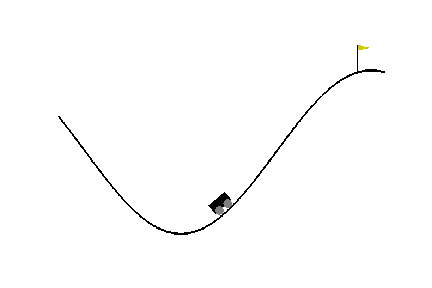
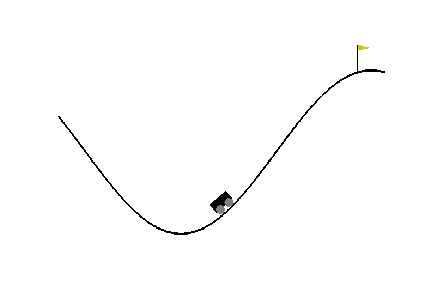
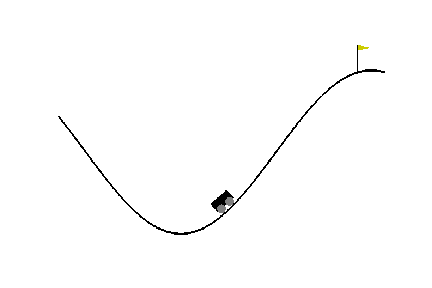
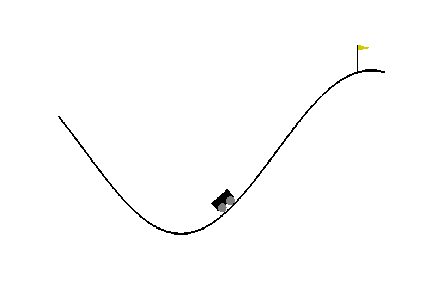
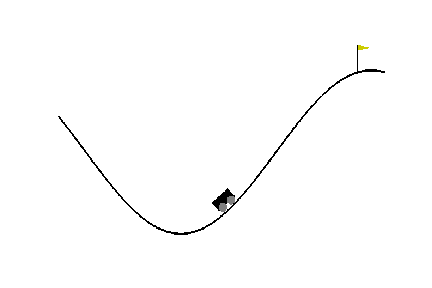
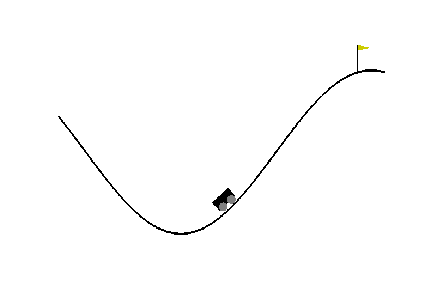
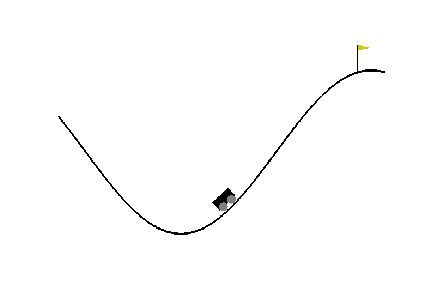
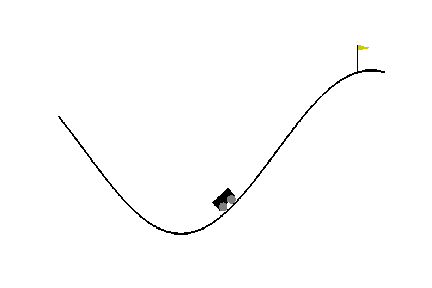
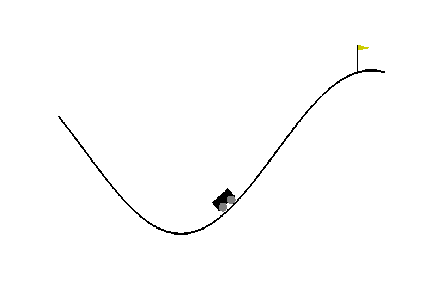
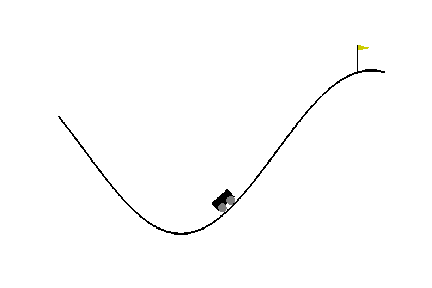
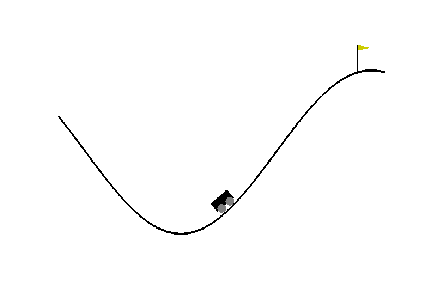
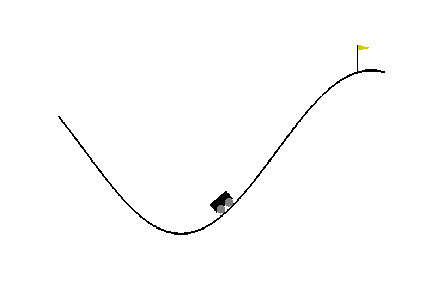
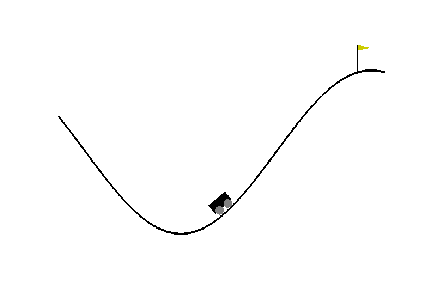
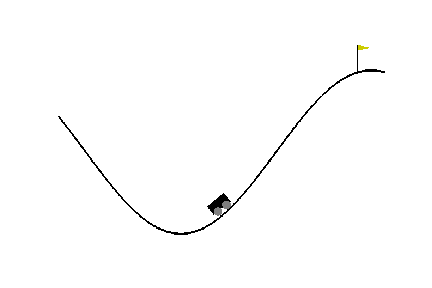
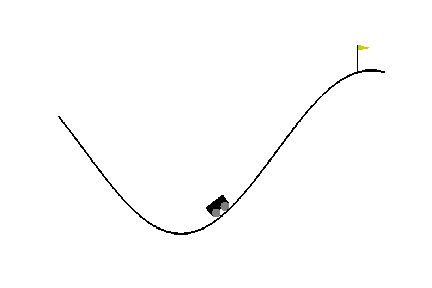
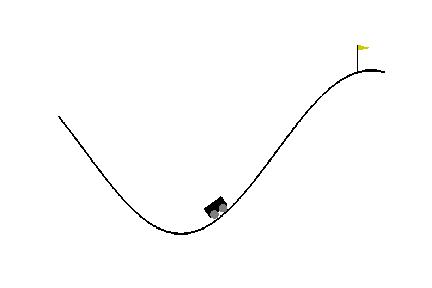
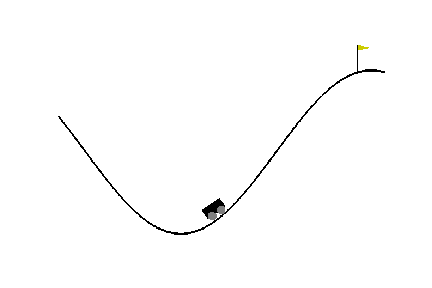
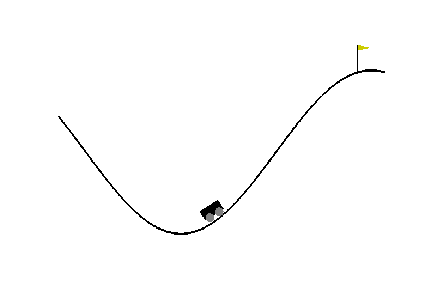
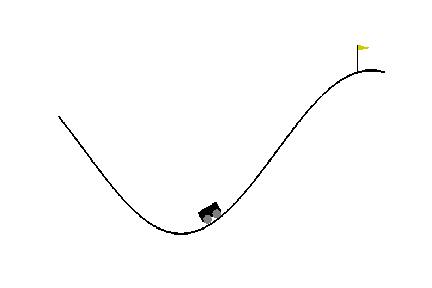
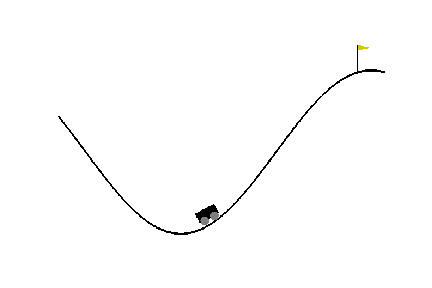
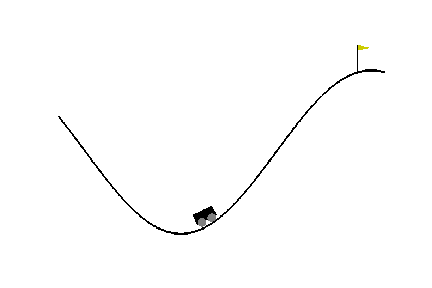
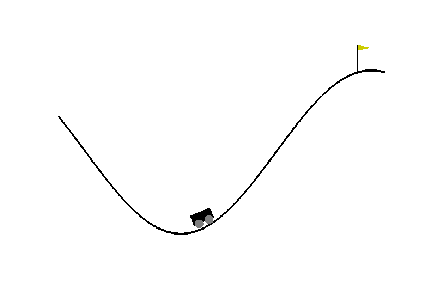
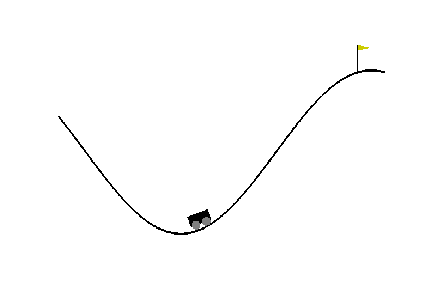
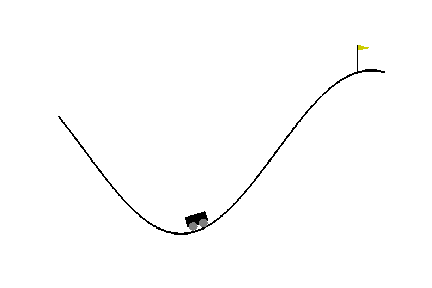
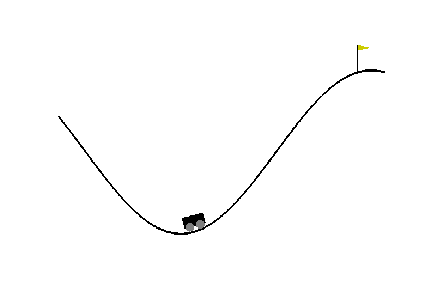
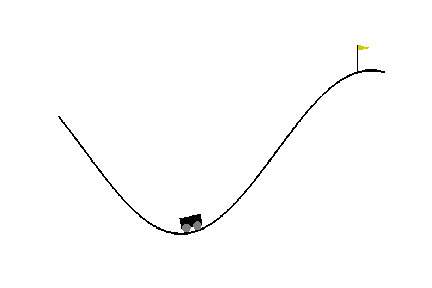
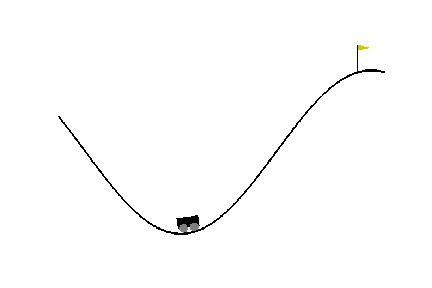
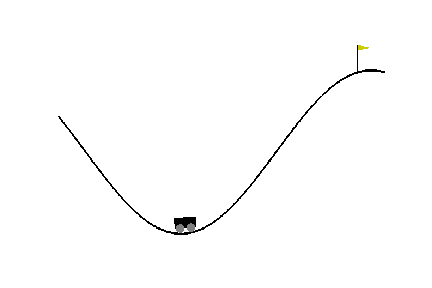
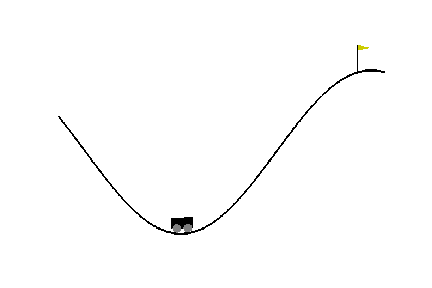
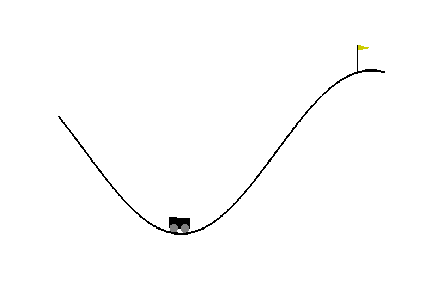
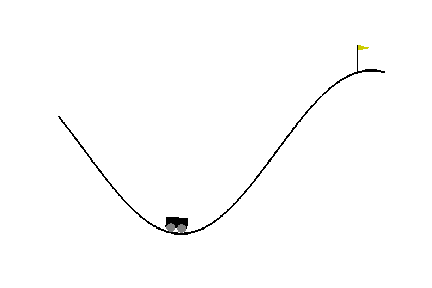
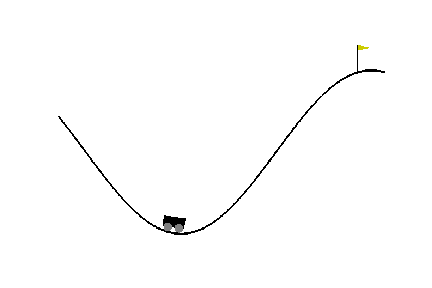
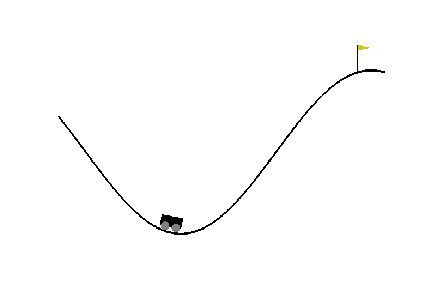
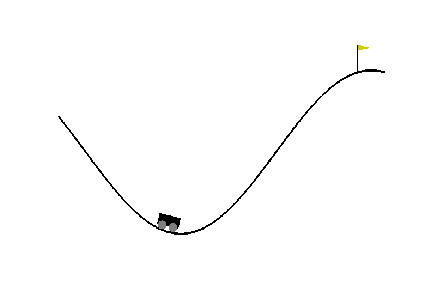
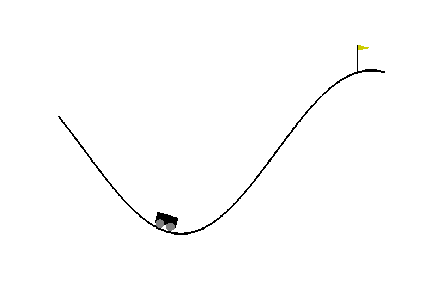
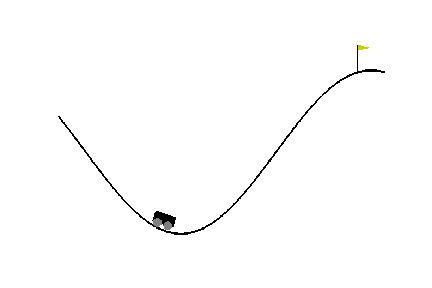
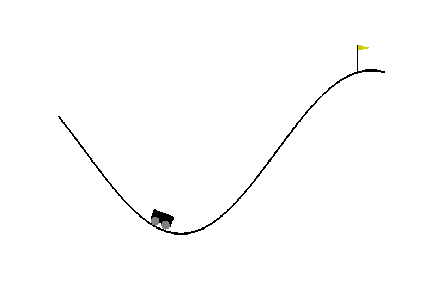
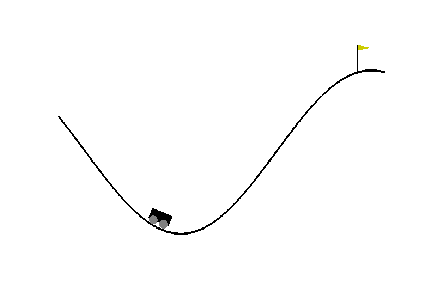
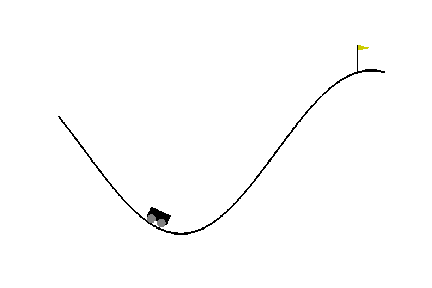
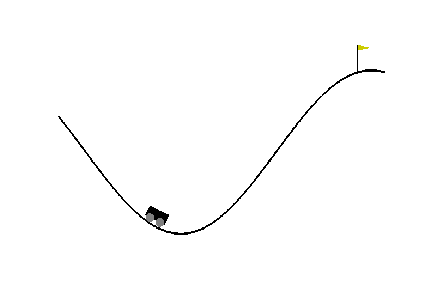
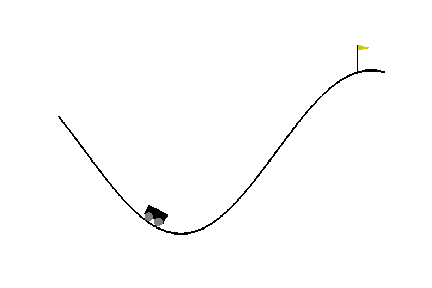
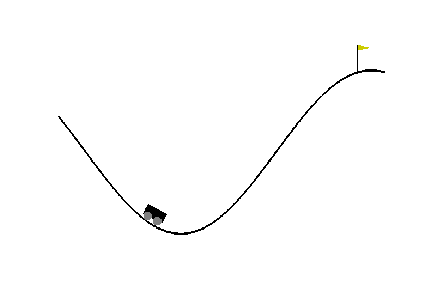
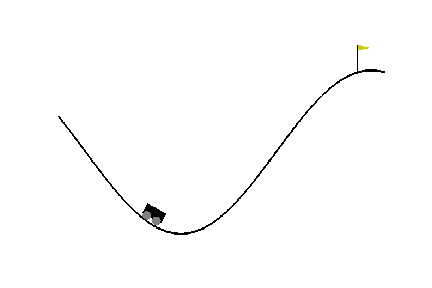
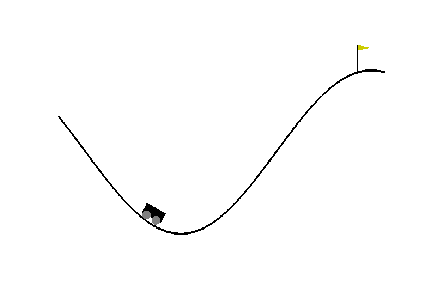
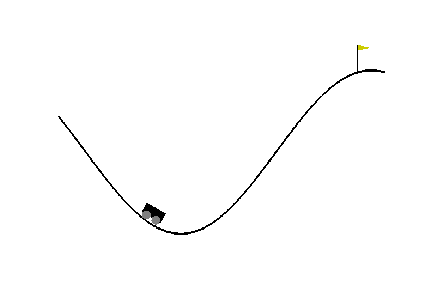
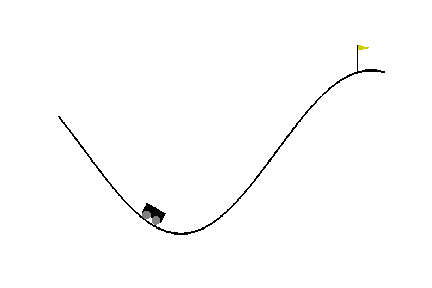
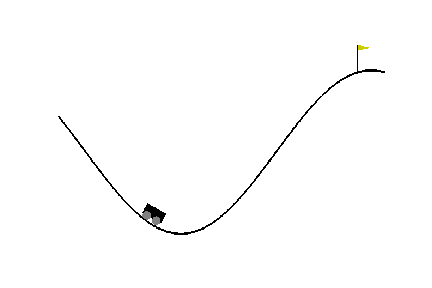
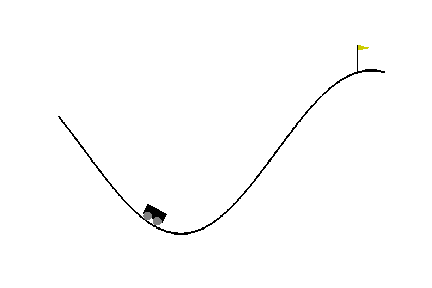
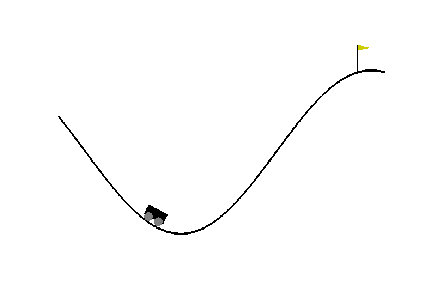
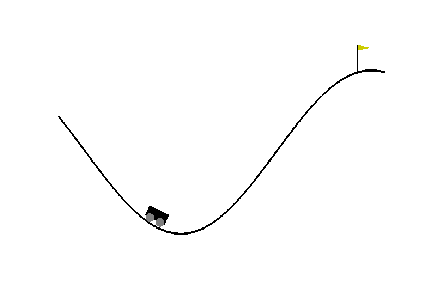
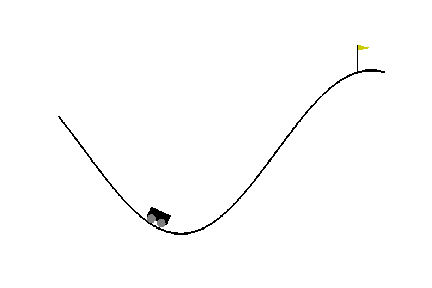
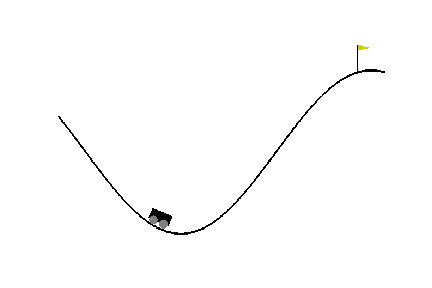
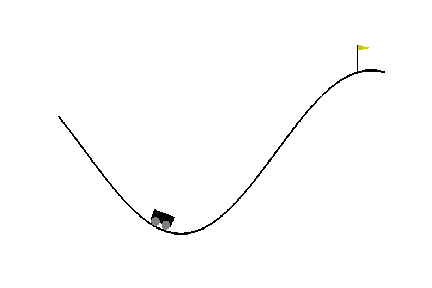
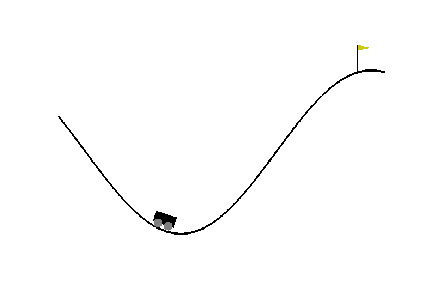
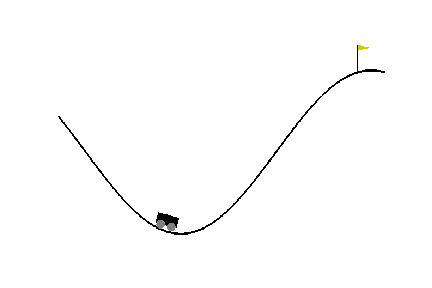
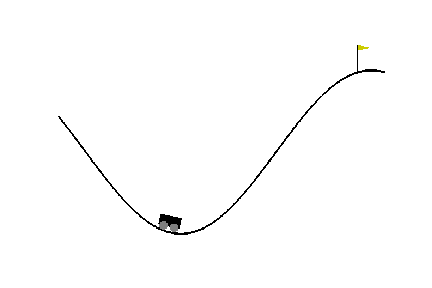
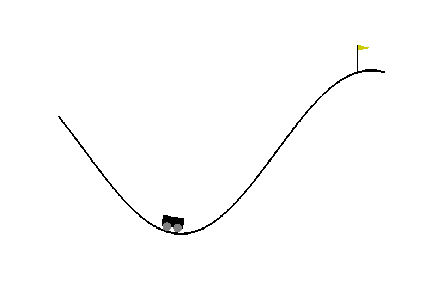
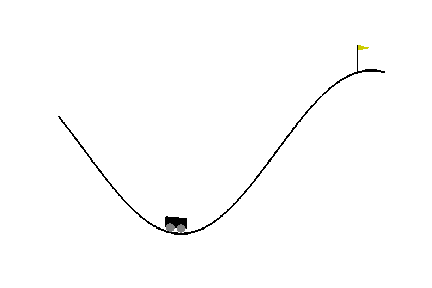
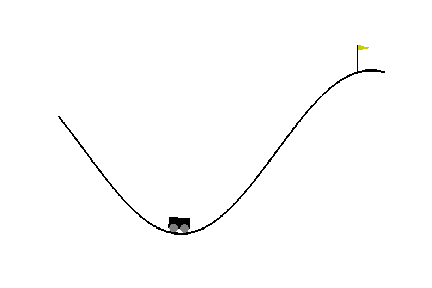
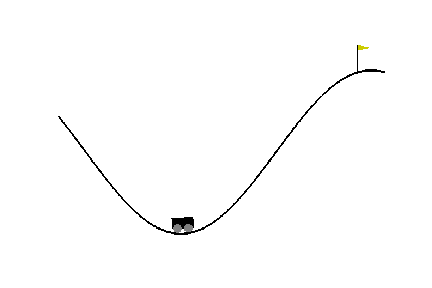
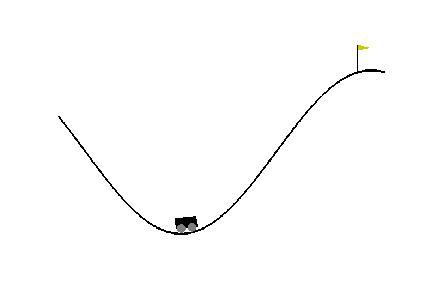
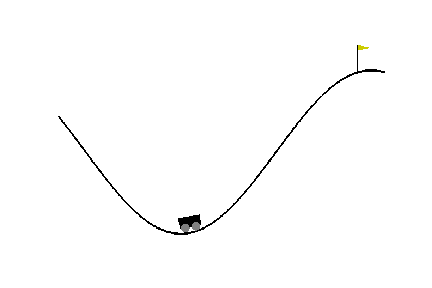
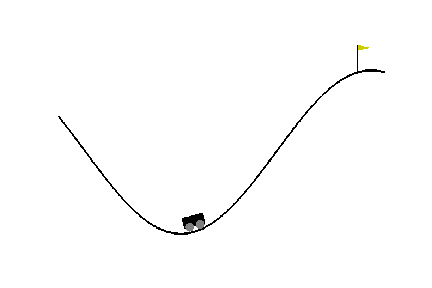
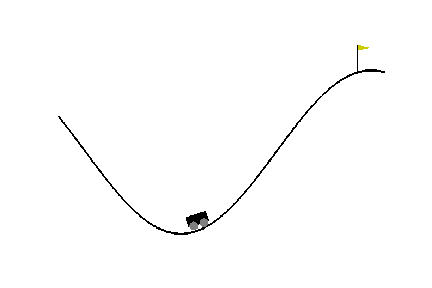
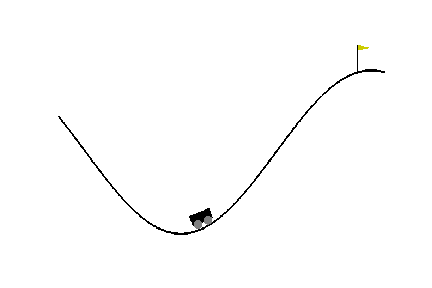
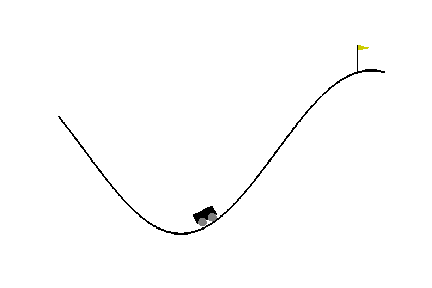
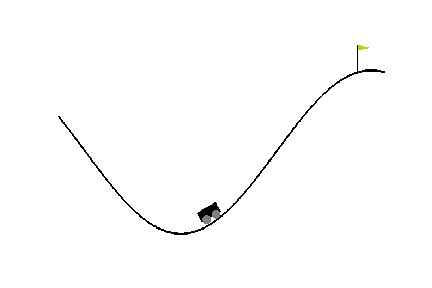
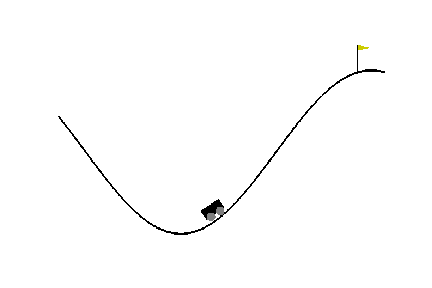
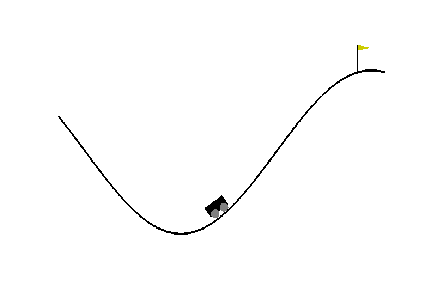
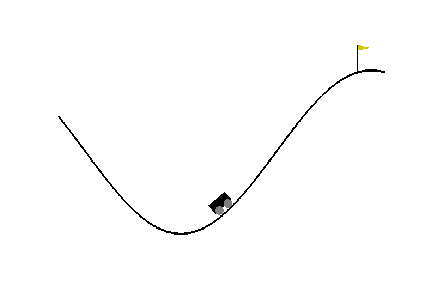
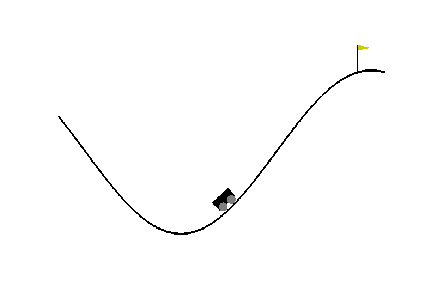
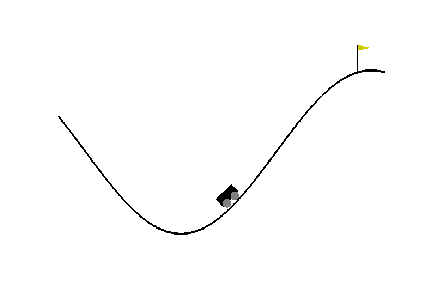
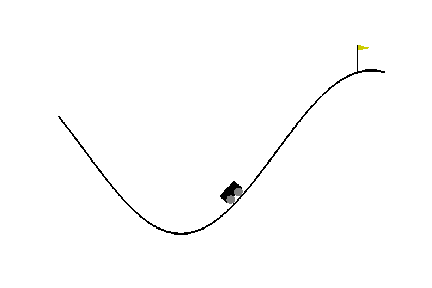
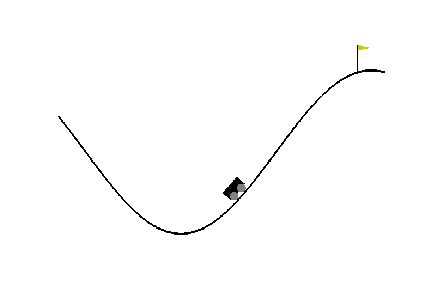
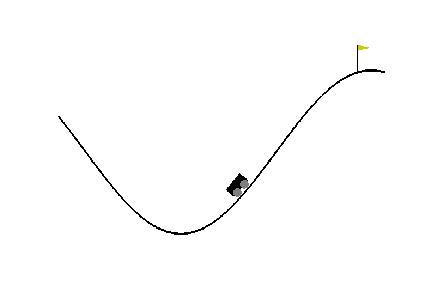
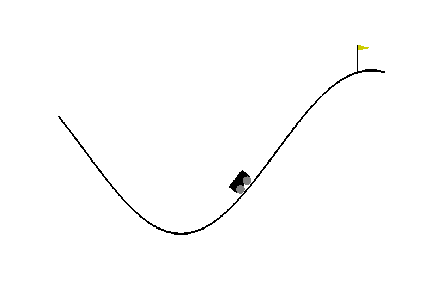
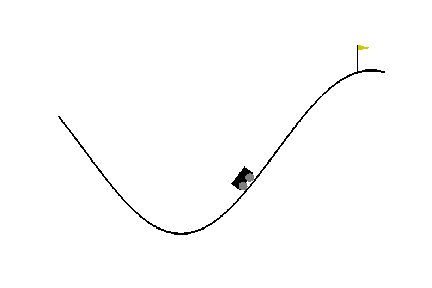
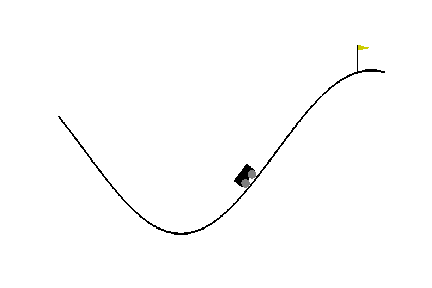
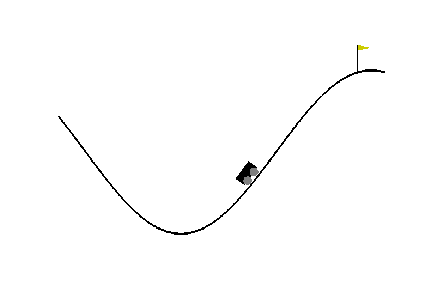
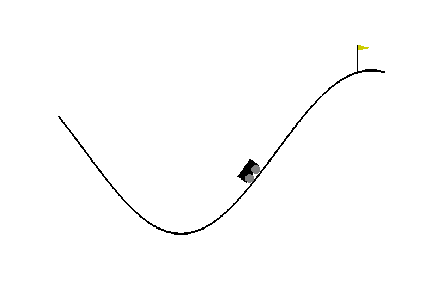
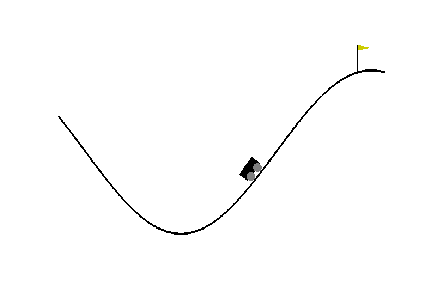
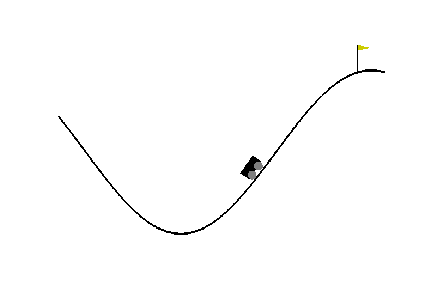
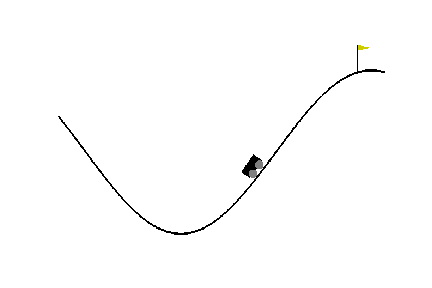
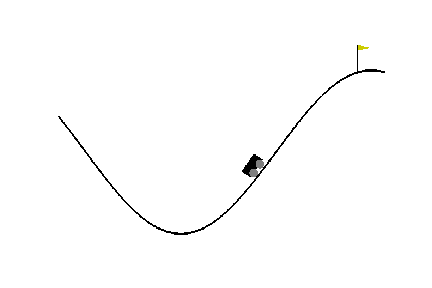
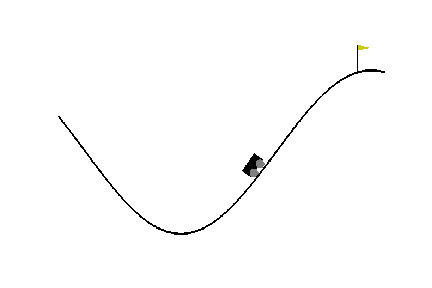
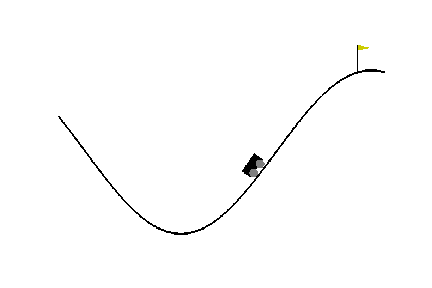
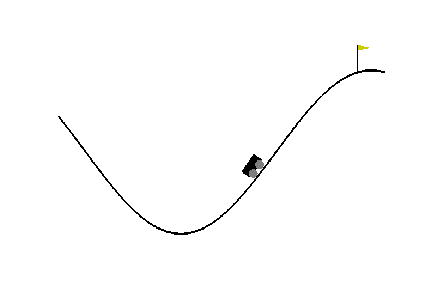
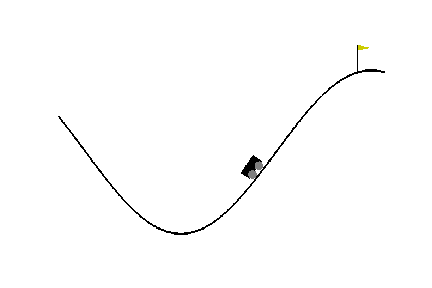
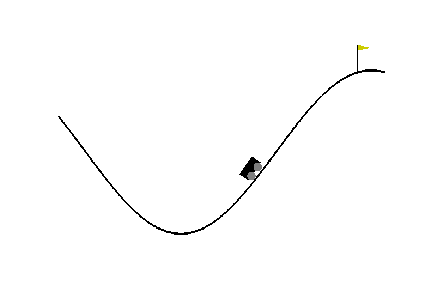
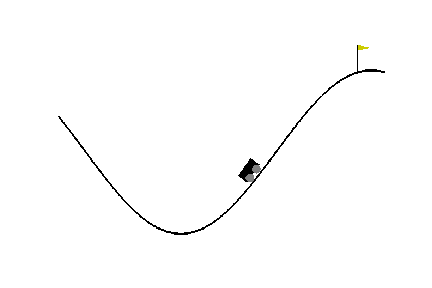
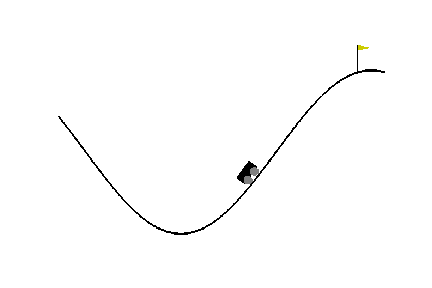
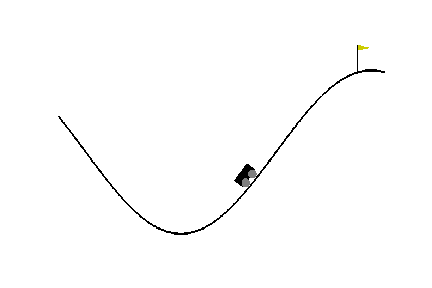
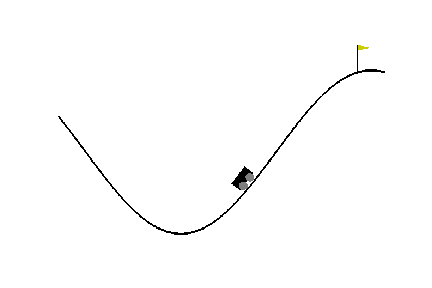
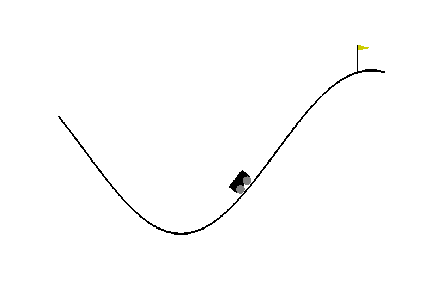
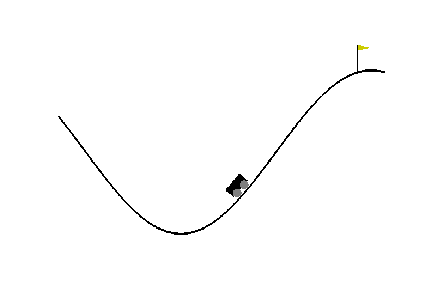
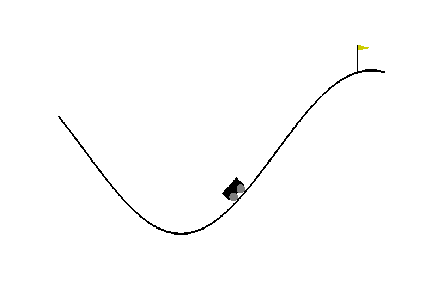
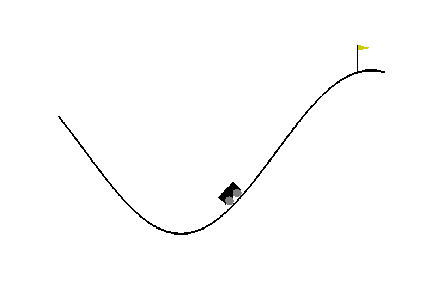
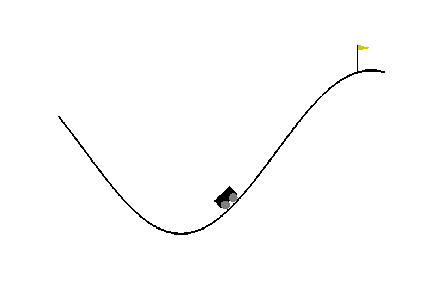
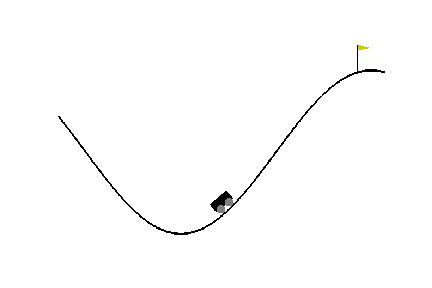
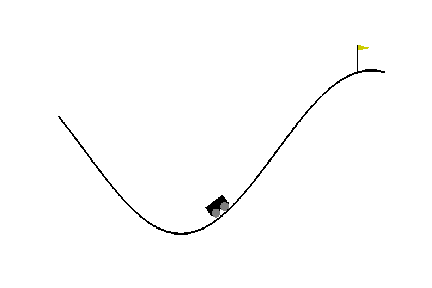
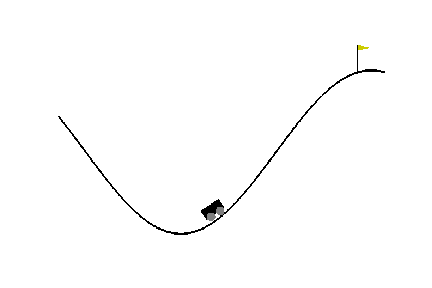
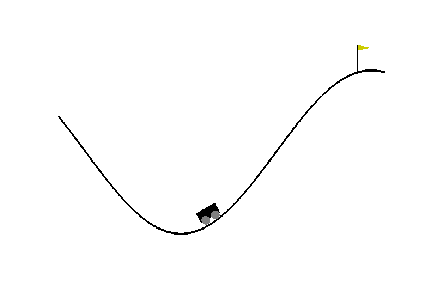
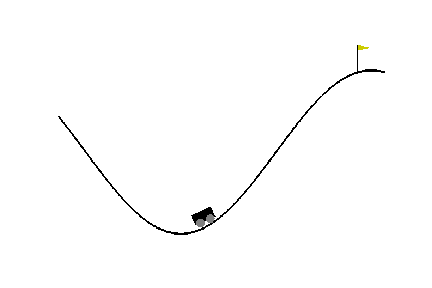
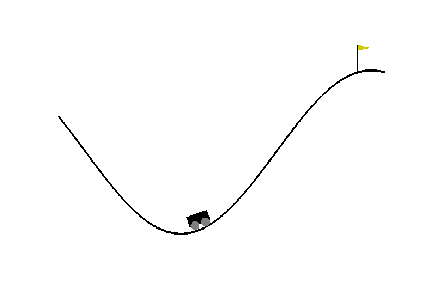
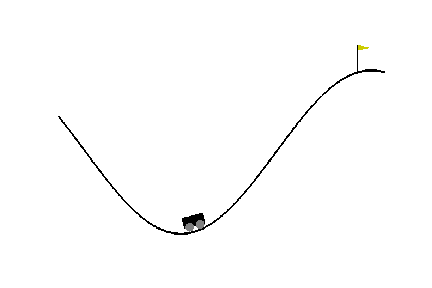
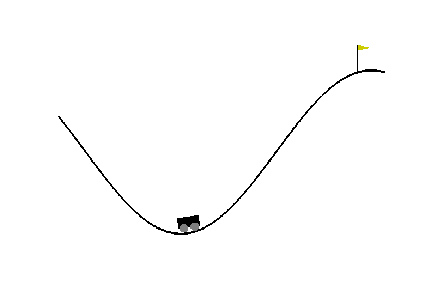
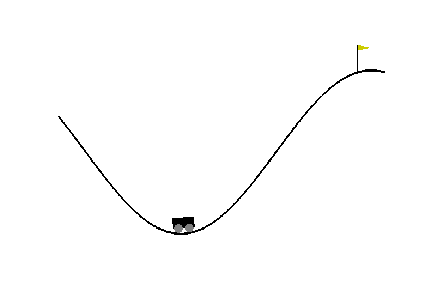
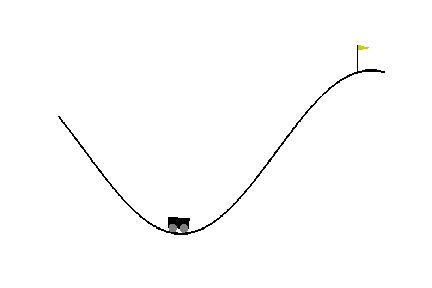
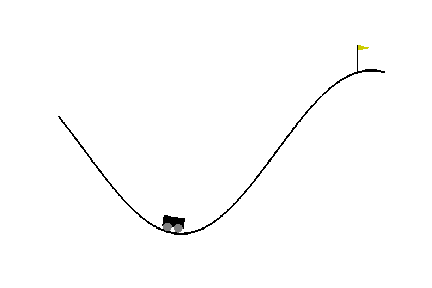
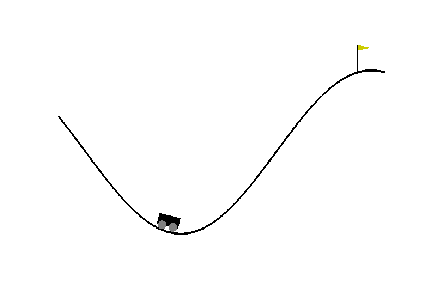
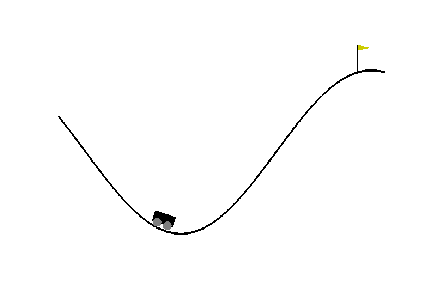
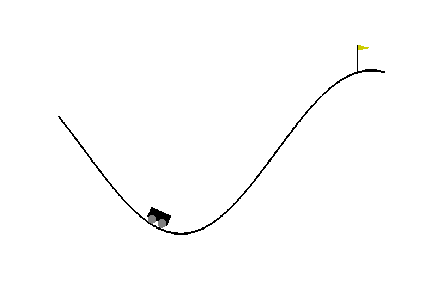
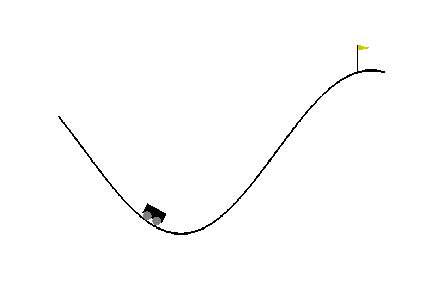
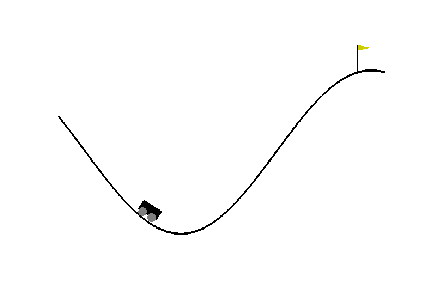
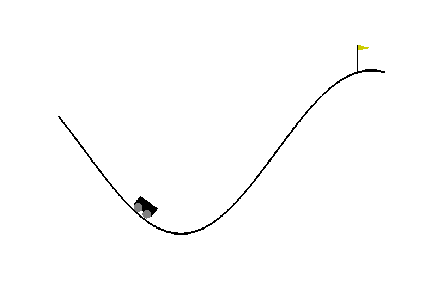
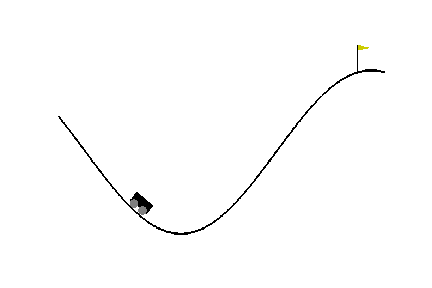
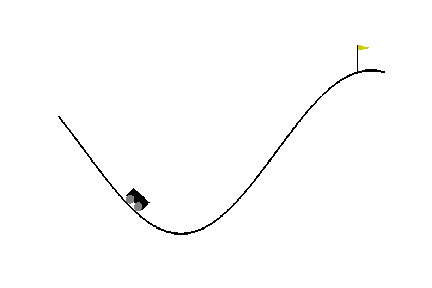
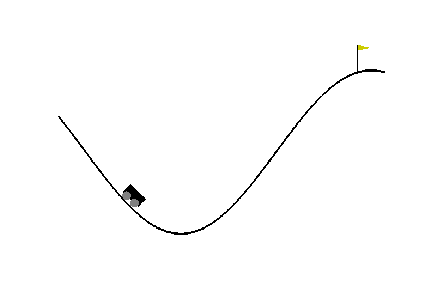
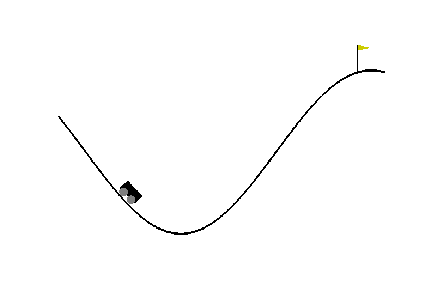
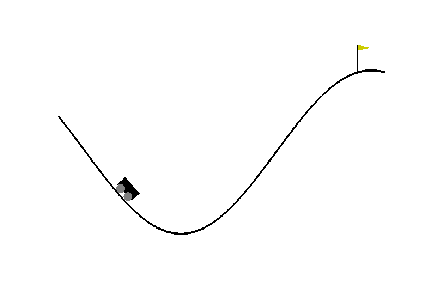
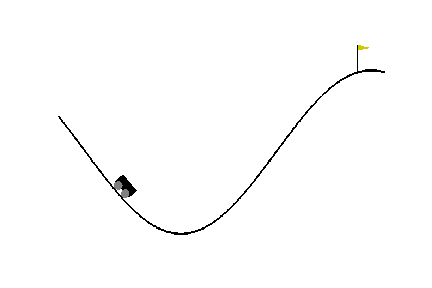
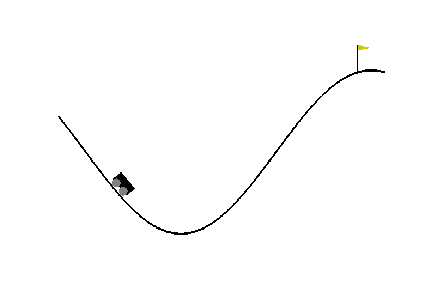
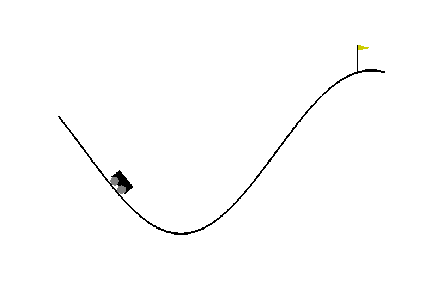
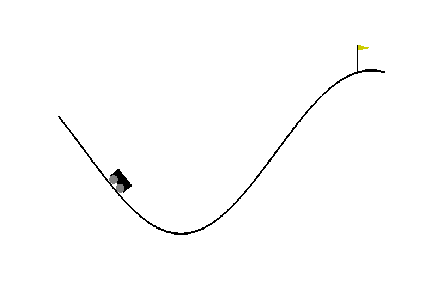
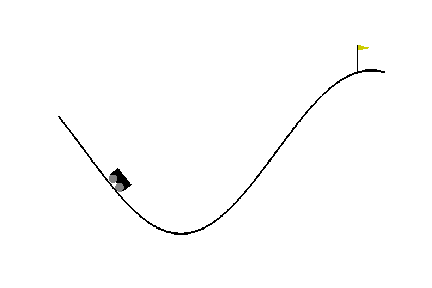
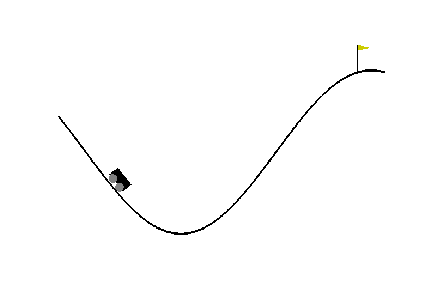
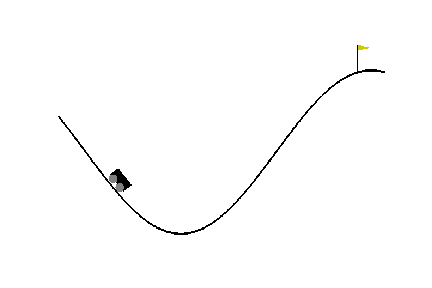
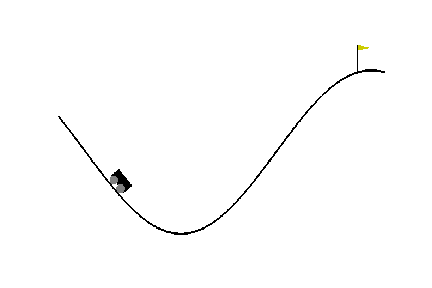
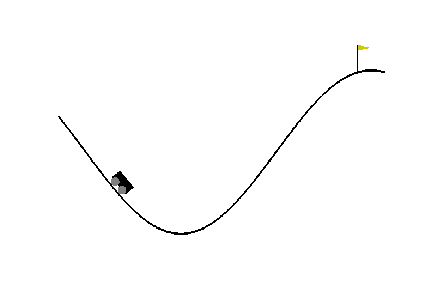
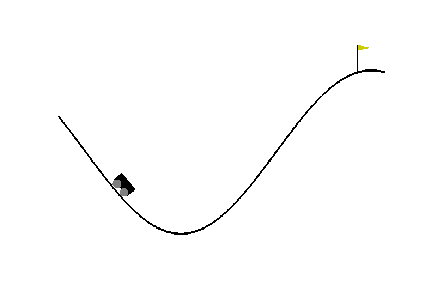
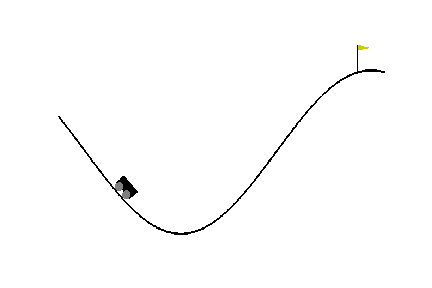
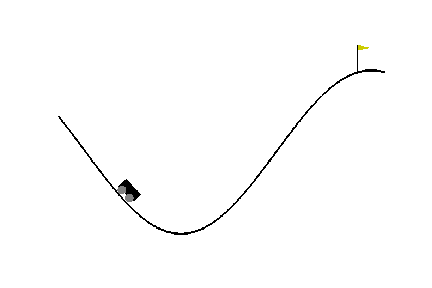
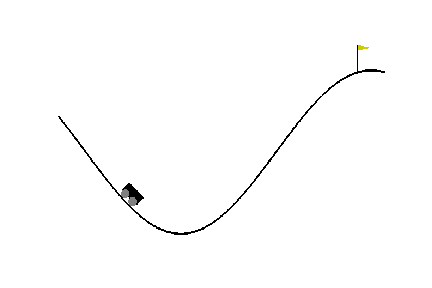
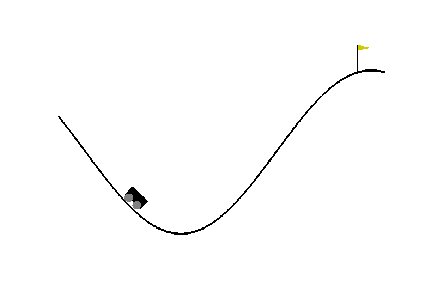
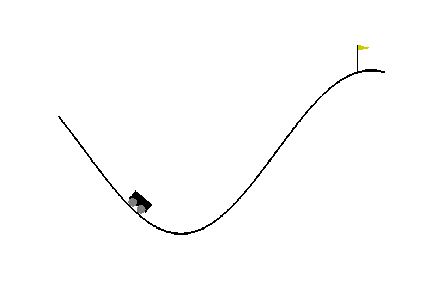
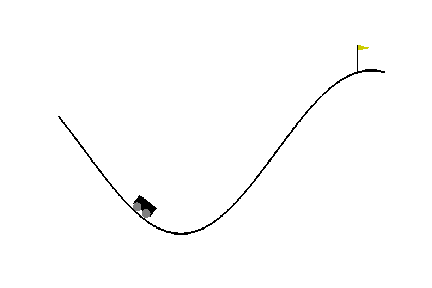
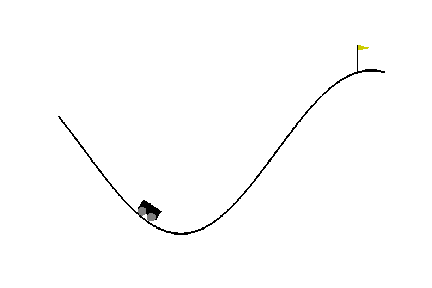
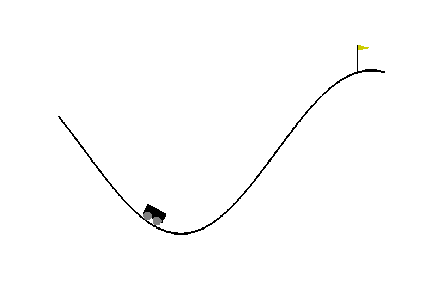
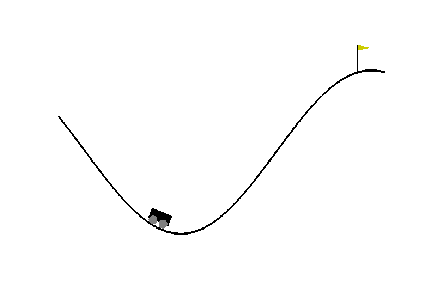
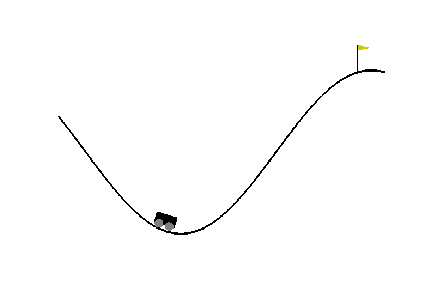
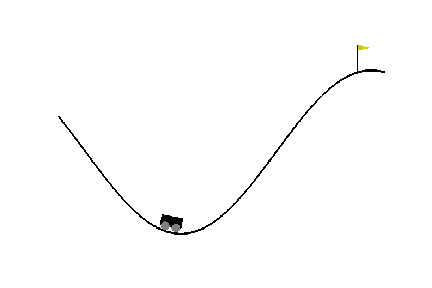
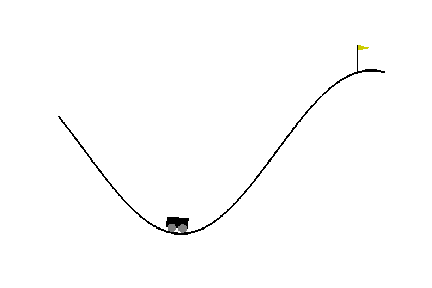
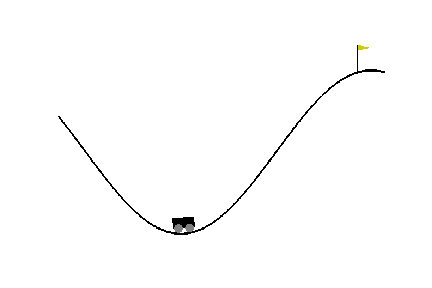
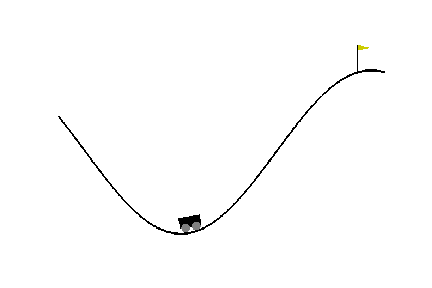
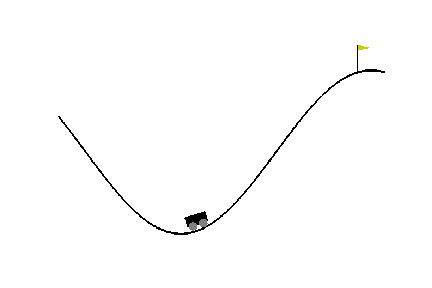
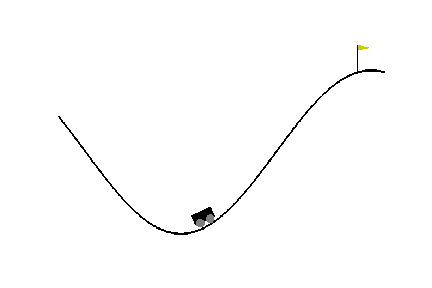
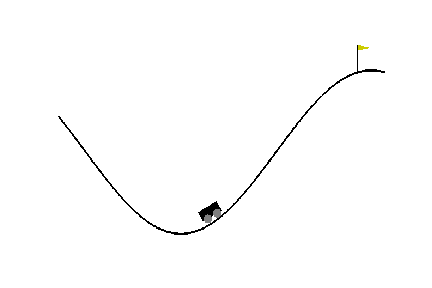
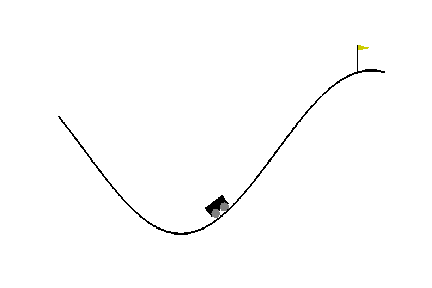
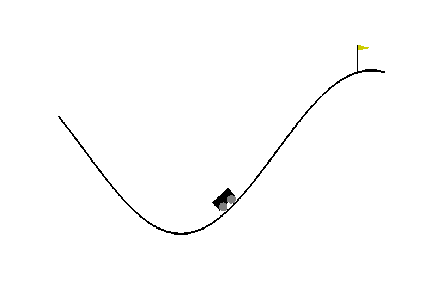
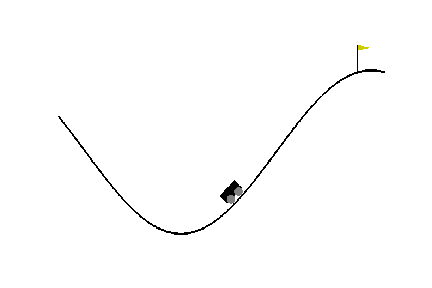
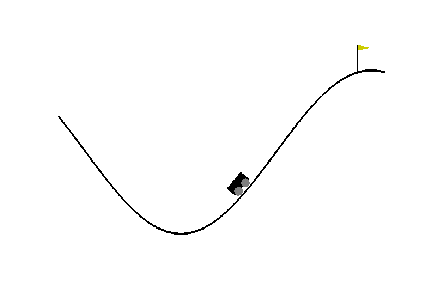
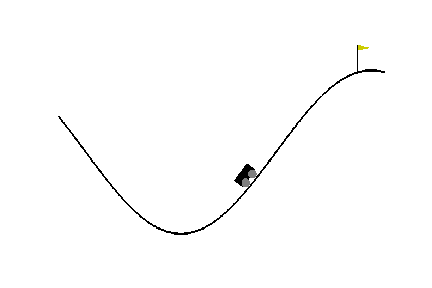
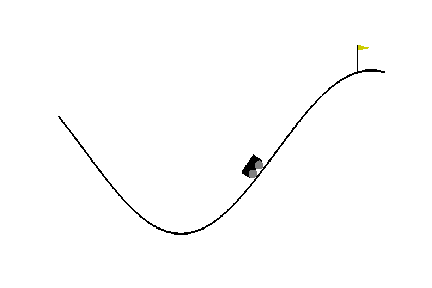
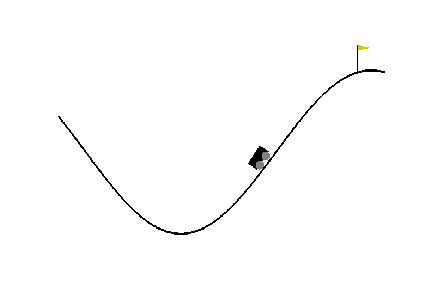
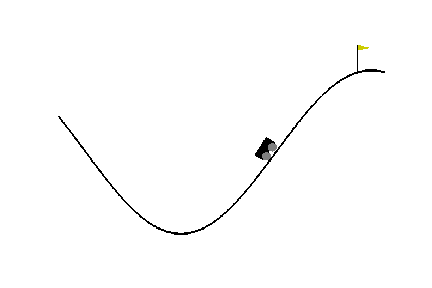
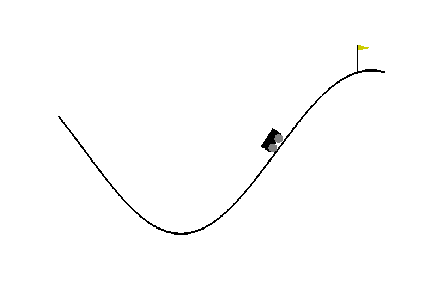
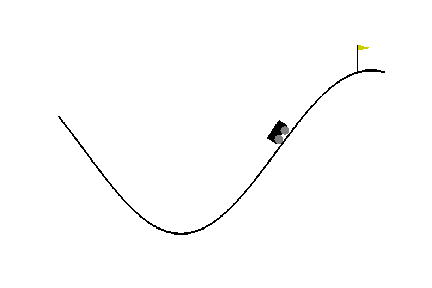
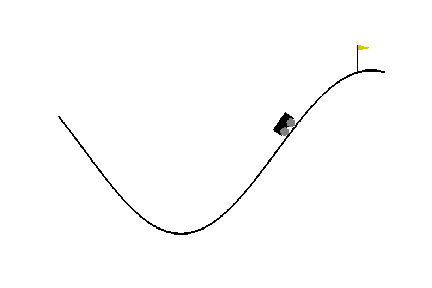
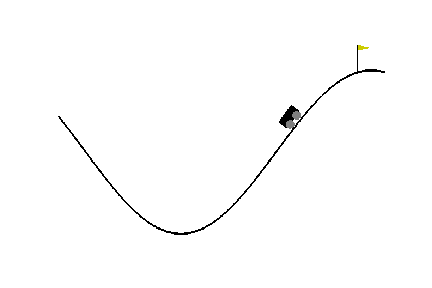
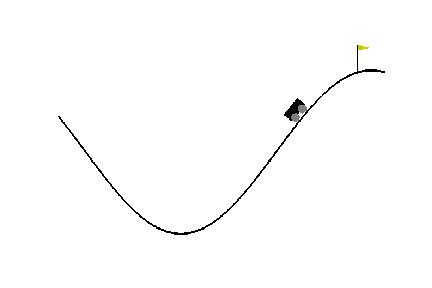
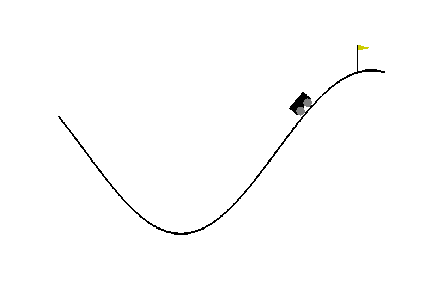
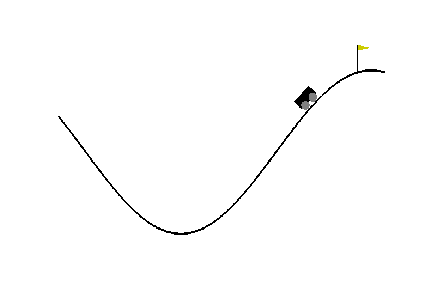
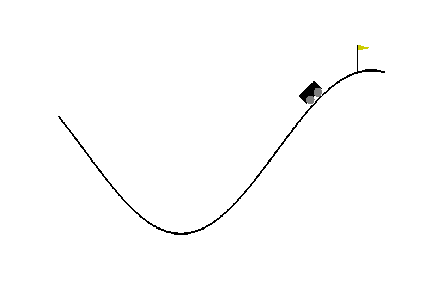
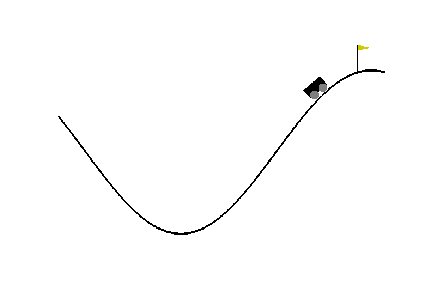
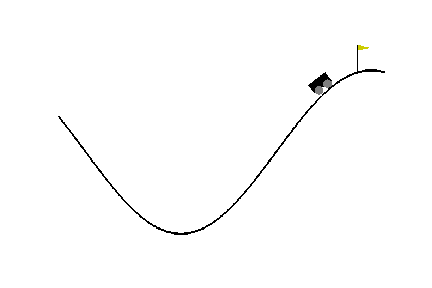
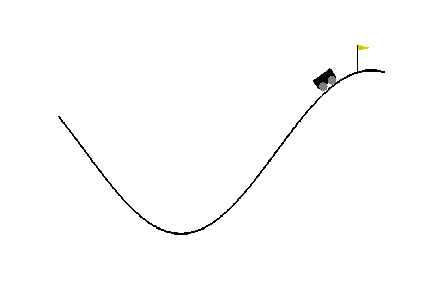
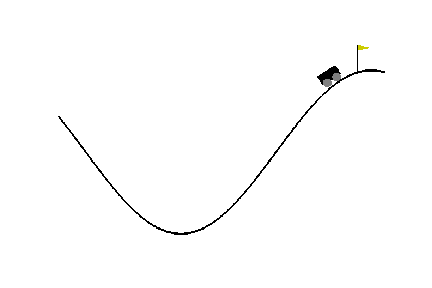
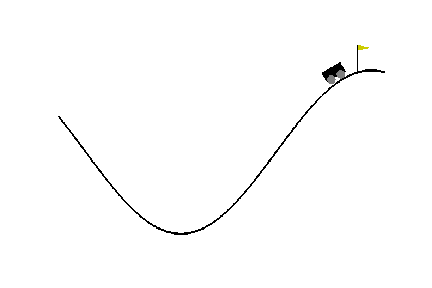
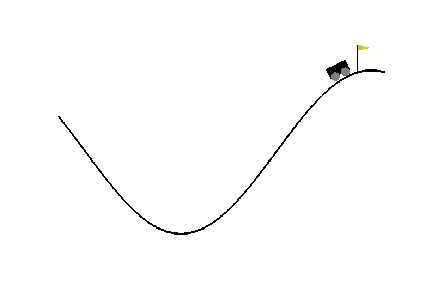
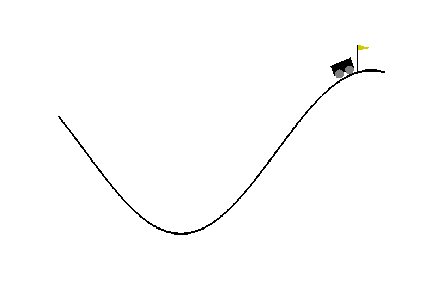
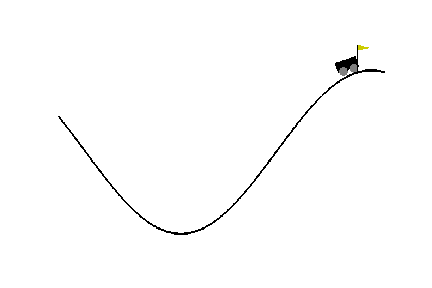
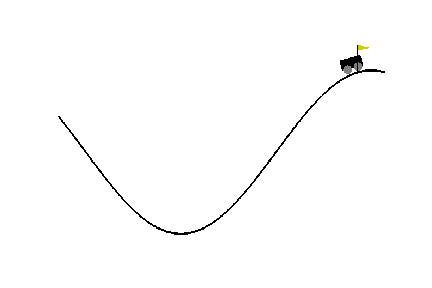

In [5]:
env = gym.make(envname)
obs = env.reset()
obs = np.reshape(obs, [1, -1])
total_reward = 0
frames = []
for t in range(10000):
    # Render into buffer. 
    frames.append(env.render(mode='rgb_array'))
    nz_obs = (obs - demo_obs_mean) / demo_obs_std
    action = gp.predict(nz_obs)
    obs, reward, done, info = env.step(action)
    obs = np.reshape(obs, [1, -1])
    total_reward += reward
    if done:
        break
env.close()
print('Total Reward : %.2f'%total_reward)
display_frames_as_gif(frames)